<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This tutorial is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>, except for figures of external sources as indicated. It is partly based on the tutorial prepared by Marcus Voss and Nikola Milojevic-Dupont for participants of the WiDS Datathon 2022.

CCAI Summer School Tutorial: Building Load Forecasting with ML
==============

Author: [Marcus Voss](mailto:voss.marcus@gmail.com) – *Birds on Mars, TU Berlin, Climate Change AI*

*Changelog:*
*   *2023-06-30: Adding resource and updating deprecated Tensorflow wrapper*
*   *2024-05-26: Adding forecasting book as reference for further reading. Adding references on transformers. Adding references to new CCAI tutorials. Adding blank cells*

# Key Learning Objectives 🎯

In this tutorial, we will investigate the task of building load forecasting.

- You will get a basic understanding of using off-the-shelf ML models for time series forecasting,
- You will learn about some relevant features in short-term building load forecasting (and load forecasting generally),
- You will be aware of some common pitfalls when evaluating load forecasting models.

Some concepts learned may also be helpful for other time series tasks beyond load forecasting.


# Outline ⏰
1. [Introduction](#introduction)
  1. [Motivation](#motivation)
  1. [Load Forecasting at Different Spatial and Time Dimentions](#taxonomy)
  1. [Overview of Forecasting Methods](#forecastingmethods)

1. [Intro to Load Forecasting using Machine Learning](#intro)
    1. [Time Series Data in Pandas](#pandas)
    1. [Time Series Forecasting as a Machine Learning Problem](#tsforecasting)
    1. [Exploratory Data Analysis](#eda)
    1. [Load Forecasting Feature Candidates](#features)
    1. [Encoding Cyclic Calendar-based Features](#cyclic)

1. [Example Case Study Load Forecasting](#casestudy)
    1. [Generating Feature Candidates](#featurecandidates)
    1. [Preparing the model inputs and target](#inputoutput)
    1. [Fitting some baseline models](#baseline)
    1. [Comparing Encodings for categorical variables](#encodings)
    1. [Fitting a neural network using Tensorflow](#ann)
    1. [Model diagnostics](#diagnostics)

1. [Common Pitfalls](#pitfalls)
   1. [One-step ahead forecasting](#onestepahead)
   1. [Cross-validation for time series](#crossvalidation)

1. [Where to go from here?](#sota)
1. [References](#references)
1. [Selected Ressources on Time Series](#ressources)



# Introduction 💡 <a name="introduction"></a>






## Motivation <a name="motivation"></a>
Accurate local short-term load forecasts at the building level ranging from minutes to days ahead are becoming essential for building- and district operators but also grid operators and utilities to make informed decisions within many applications.

On the building operator site, short-term forecasts are mainly used to inform the energy management system for optimal energy supply, e.g., to control storage and supply options. Surplus energy can also be traded at local and peer-to-peer, and community energy markets and demand response can be provided through real-time pricing schemes or other flexibility applications emerging with the energy transition to a more sustainable and decentralized energy supply.

Short-term forecasts of the local load can further be conducted by the grid operators themselves, for instance, for better peak load reduction, voltage control, grid state estimation, and anomaly detection to increase resilience for the grid or to detect energy theft. For other grid-side applications see a review in [1].

## Load Forecasting at Different Spatial and Time Dimentions <a name="taxonomy"></a>
Forecasts of demand and supply are generally an essential task in the energy transition and hence climate change mitigation (see also [2]). With a trend to decentralization, forecasts are needed in all *spatial dimensions* from the country-level and the level of high voltage transmission systems down to individual buildings, households, and even devices (typically large devices like electric vehicles or heat pumps). The following figures shows how the load profiles changes for different aggregation levels on the left. One can see that the profiles as the individual household level are a lot less regular. This leads to increased forecast errors for individual households (see the exemplary empirical forecast errors from a simple forecast model). Read more in [Chapter 2](https://link.springer.com/chapter/10.1007/978-3-031-27852-5_2) in [4] on the characteristics of building-, household- and generally low voltage-level loads.

|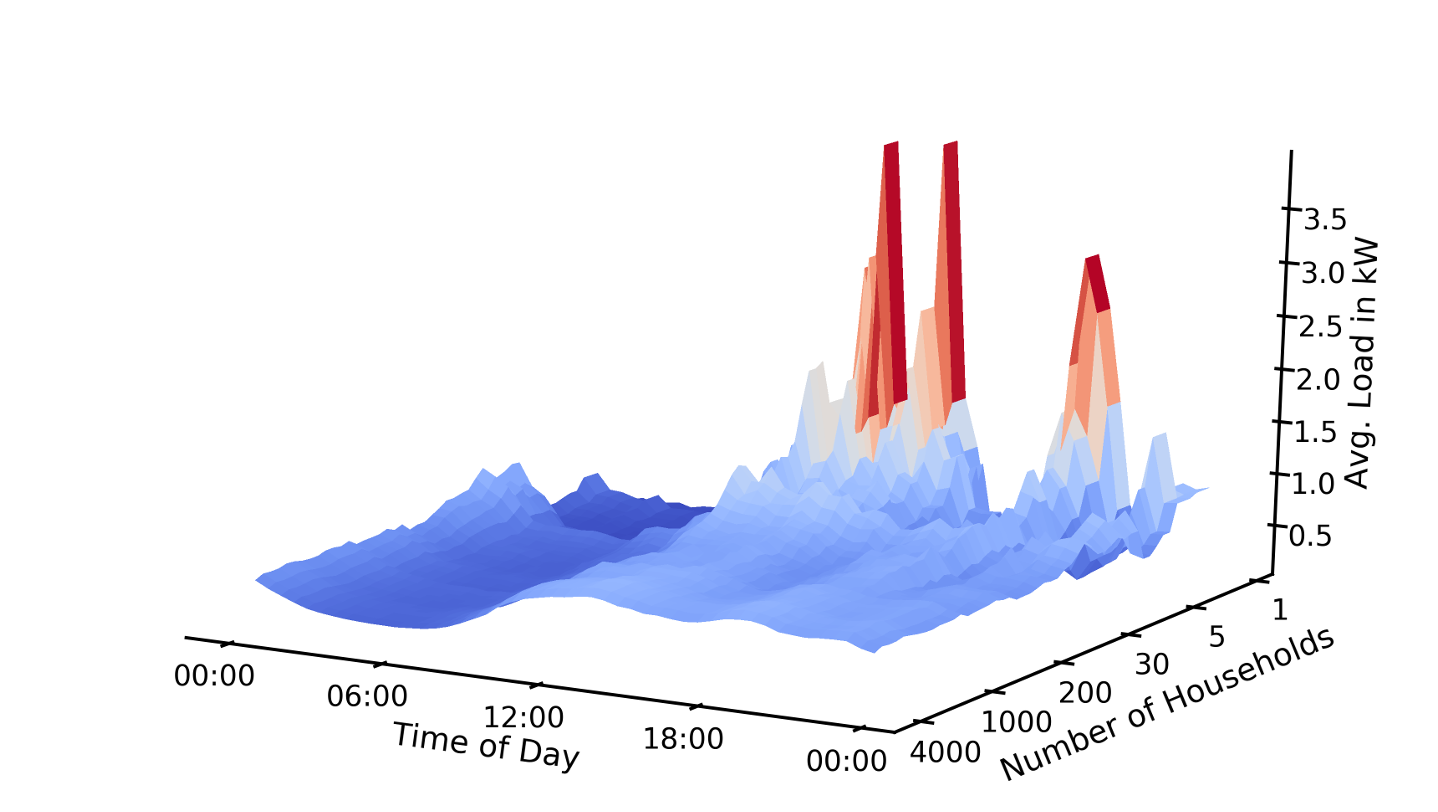| 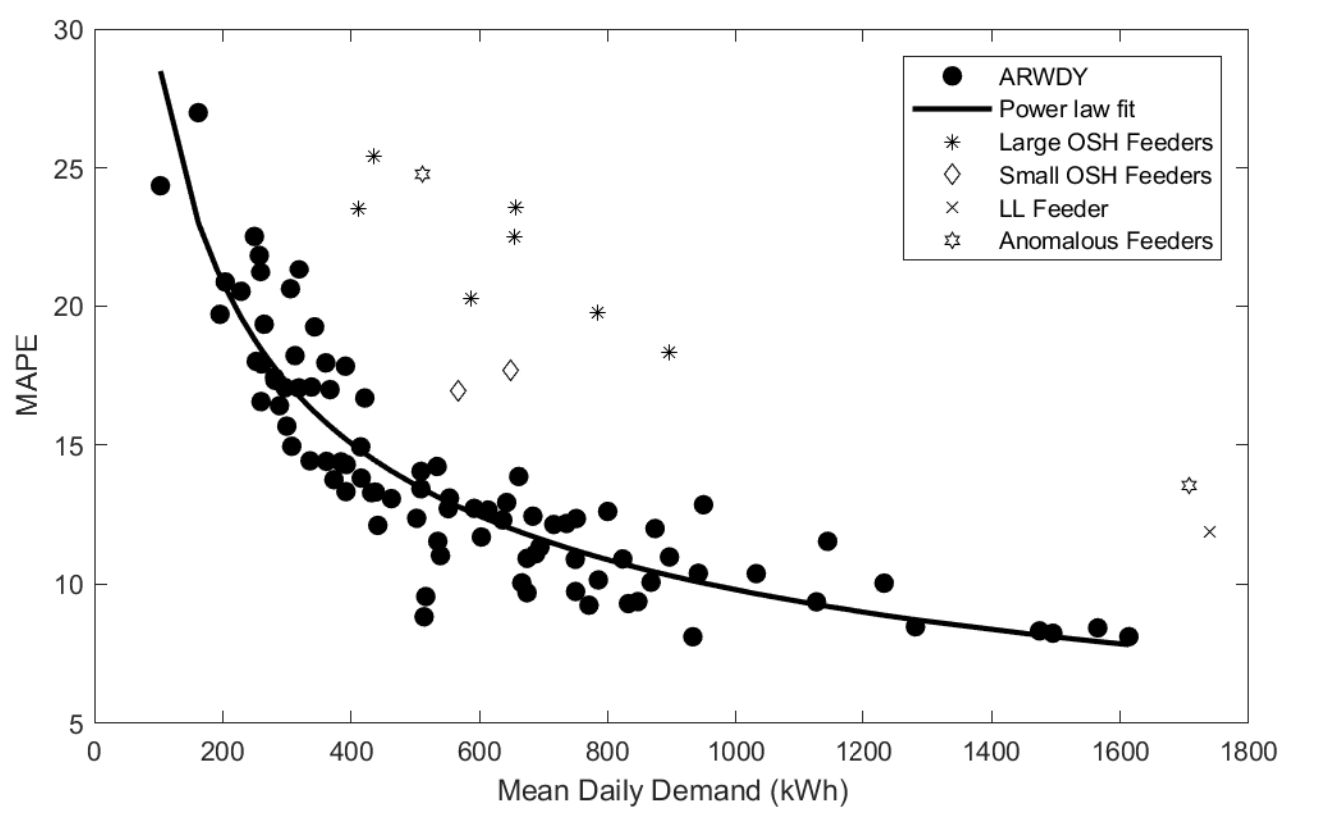|
|:--:|:--:|
| *Source: Own figure inspired by Phil Grünewald| *Source: [1]*|



Besides the spatial dimension, forecasts are also needed in different *time horizons*, depending on the task. *Short-term* and *very-short term forecasts* of minutes to a few days ahead are needed, for instance, for real-time scheduling tasks to reduce the reliance on polluting standby plants and to manage increasing amounts of variable sources proactively. *Long-term forecasts* of weeks and years ahead can help system operators (and investors) to determine where and when to build, for instance, variable renewable plants. While the taxonomy of short- and long-term forecasts is not very clearly defined, the following figure gives an overview of how the terms are typically used:

|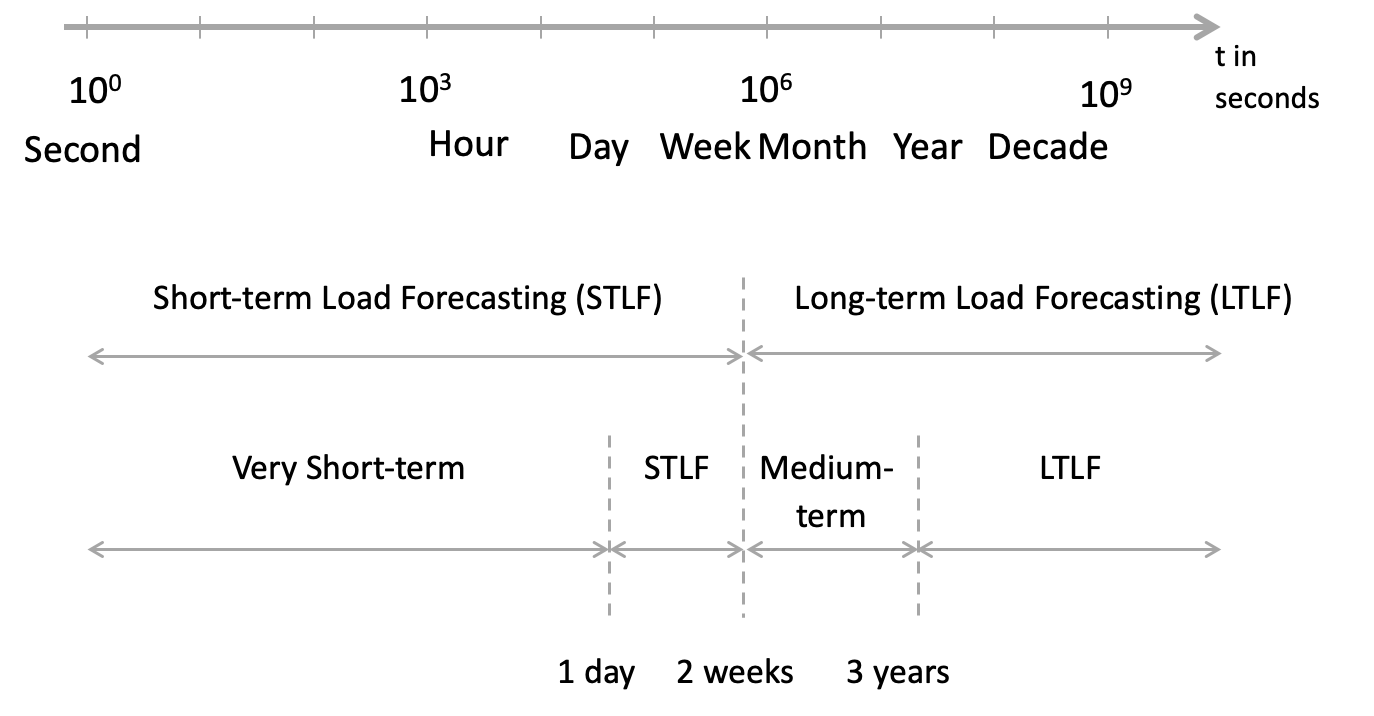|
|:--:|
| *Source: Based on figure from *Probabilistic electric load forecasting: A tutorial review. International Journal of Forecasting, Hong, T., & Fan, S., 2016)**|



## Overview of Forecasting Methods <a name="forecastingmethods"></a>

The time series forecasting task, in general, has for a long time been approached by *parametric* and *statistical methods* that have been specially designed to handle time series. Examples are autoregressive models (AR) and their extensions ARMA, ARIMA, and ARIMAX or models based on exponential smoothing (see Chapters 7-10 of this [free online book](https://otexts.com/fpp3/) or [Chapter 10](https://www.springerprofessional.de/en/benchmark-and-statistical-point-forecast-methods/25303778) on some classical forecasting models). As in many domains in recent years, machine learning models have increasingly been applied to forecasting problems. In contrast to many other domains like image recognition or natural language processing, in time-series forecasting they have not been yet completely dominating over other approaches in the field, like simple benchmarks and statistical approaches. This is the case because many time-series problems have limited data availability, and algorithms were often unnecessarily complex and limit human interpretability.

Only in recent years have machine learning models, for instance using neural networks or gradient boosting, started to consistently outperform other methods (see for instance the discussion of the [Kaggle M5 time series forecasting competition](https://www.kaggle.com/c/m5-forecasting-accuracy) in *The M5 accuracy competition: Results, findings and conclusions. International Journal of Forecasting, Makridakis, S and Spiliotis, E and Assimakopoulos, V. 2020*). Initially, fully connected neural networks were applied, but also recurrent neural networks and variants like Long-Short Term Memory (LSTM, see [this](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) good introduction) were applied with some success. More recently, convolutional neural networks (CNN) have been applied with quite some success. They are generally more efficient to train then recurrent neural network architectures. [WaveNet](https://deepmind.com/blog/article/wavenet-generative-model-raw-audio) first popularized techniques like causal and dilated convolutions to treat the auto-regressive nature of time series (see figure below), which have since been popularised within the family of Temporal Convolutional Networks (TCN).

| <img src="https://lh3.googleusercontent.com/Zy5xK_i2F8sNH5tFtRa0SjbLp_CU7QwzS2iB5nf2ijIf_OYm-Q5D0SgoW9SmfbDF97tNEF7CmxaL-o6oLC8sGIrJ5HxWNk79dL1r7Rc=w2048-rw-v1" alt="WaveNet" style="float: left; margin-right: 10px;" /> |
|:--:|
| Source: [DeepMind](https://deepmind.com/blog/article/wavenet-generative-model-raw-audio) |

With the advent of specialized deep learning approaches like [DeepAR](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html) and [N-BEATS](https://arxiv.org/abs/1905.10437) there is a trend that more advanced specialized machine learning models will improve in many time series problems. More recently also transformer based models have been introduced, like [Informer](https://arxiv.org/abs/2012.07436) and [Autoformer](https://arxiv.org/abs/2106.13008). 

This leaves the question of what methods to apply?

**When are statistical/parametric models good?**
Typically, statistical and traditional time series models perform well for *local models*, i.e., when one model is fit for one specific instance, like one building or household. Further, when the data is of low resolution (e.g., daily, weekly, or yearly time series). Additionally, it performs well when covariates like seasonalities and other external influences are well understood.

**When are Non-parametric/data-driven/machine learning methods good?**
Machine learning models tend to perform better when fitting models across multiple time series, like one model for multiple buildings or households (*global models*) or hierarchical models. In probabilistic forecasting, they perform well when densities are complex (e.g., multi-modal). Further, they can be useful when fitting models to processes with complex, non-linear external influences.

However, one important finding of the M5 competition was that **combinations** of statistical and machine learning models can reach state-of-the-art results with the advantage of remaining at least partly interpretable, combining advantages of both and hence being particularly interesting for real-world applications.

Read more in [Chapter 13](https://www.springerprofessional.de/en/advanced-and-additional-topics/25303758) of [4] on forecast combinations and global vs. local modelling (or hybrid schemes). 


## 👉 *Main Take Away Messages*
- *Load forecasting can help to more efficiently align demand and supply in an energy system with uncertain renewable supply at different time scales (short, medium, and long-term) and spatial scales.*
- *Depending on your specific problem (meter resolution, spatial scale, forecast horizon, relevant features), machine learning models may or may not significantly outperform statistical time series models.*

# Intro to Load Forecasting using Machine Learning 📈 <a name="intro"></a>



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

stock2 = pd.DataFrame()
stock2.loc[:, "random_number"] = np.random.choice([-1, 1], size=299, replace=True)
stock2.loc[:, "random_walk"] = stock2["random_number"].cumsum()
stock2.loc[:, "Close"] = stock2["random_walk"] + 120

DATA_URL = "https://gist.githubusercontent.com/marcus-voss/b5fcbc82adff8f227fe8e8ee126c5f87/raw/b4b7d89425d5e7a60bec95d347b7139476603216/load_data.csv"

2024-06-04 13:37:03.657416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Time Series Data in Pandas <a name="pandas"></a>

Time series data can be handled by pandas out-of-the-box. For, instance, one can read in data and create a DatatimeIndex by parsing a date column:

In [2]:
DATA_URL = "https://gist.githubusercontent.com/marcus-voss/b5fcbc82adff8f227fe8e8ee126c5f87/raw/b4b7d89425d5e7a60bec95d347b7139476603216/load_data.csv"

data = pd.read_csv(DATA_URL, parse_dates=[0], index_col=0)
data.head()

,load,temperature
date,,
2015-01-01 00:00:00-06:00,6.378,3.22
2015-01-01 01:00:00-06:00,6.134,3.33
2015-01-01 02:00:00-06:00,6.420,3.14
2015-01-01 03:00:00-06:00,6.129,2.69
2015-01-01 04:00:00-06:00,6.687,2.53


Note the DatetimeIndex:

In [3]:
data.index

DatetimeIndex(['2015-01-01 00:00:00-06:00', '2015-01-01 01:00:00-06:00',
               '2015-01-01 02:00:00-06:00', '2015-01-01 03:00:00-06:00',
               '2015-01-01 04:00:00-06:00', '2015-01-01 05:00:00-06:00',
               '2015-01-01 06:00:00-06:00', '2015-01-01 07:00:00-06:00',
               '2015-01-01 08:00:00-06:00', '2015-01-01 09:00:00-06:00',
               ...
               '2016-12-31 14:00:00-06:00', '2016-12-31 15:00:00-06:00',
               '2016-12-31 16:00:00-06:00', '2016-12-31 17:00:00-06:00',
               '2016-12-31 18:00:00-06:00', '2016-12-31 19:00:00-06:00',
               '2016-12-31 20:00:00-06:00', '2016-12-31 21:00:00-06:00',
               '2016-12-31 22:00:00-06:00', '2016-12-31 23:00:00-06:00'],
              dtype='datetime64[ns, UTC-06:00]', name='date', length=17544, freq=None)

For many time series tasks it is useful to have regular interval time series data. Pandas provides many useful functions to *aggregate* data points to lower resolution or *interpolate* data to a higher resolution (see [their overview here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)). For instance if you want to make the Load series a daily time series, you can aggregate the series using the mean:

<Axes: xlabel='date'>

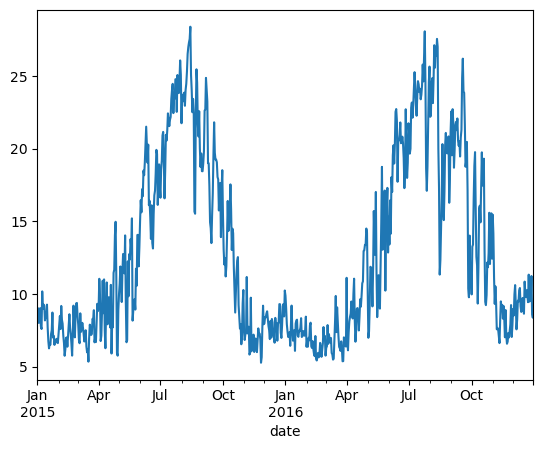

In [4]:
data.load.resample("1D").mean().plot()

## Time Series Forecasting as a Machine Learning Problem <a name="tsforecasting"></a>

Supervised machine learning algorithms aim to learn the relationship (a function **f**) between a set of input variables referred to as features (or independent variables) that are typically measured or preset and have some influence on one or several output variables. These features are often denoted as a matrix $\mathbf{X}$. When the task is to predict a numeric variable, i.e., for regression problems, the output is referred to as target (or dependent variable) and often denoted as a vector $\mathbf{y}$. The relationship between the inputs and outputs are related via the following relationships including some error $\epsilon$

$$\mathbf{y} = f(\mathbf{X})+ \epsilon$$


But how can the time series forecasting problem as in the following figure be formulated as a machine learning problem so that it can be solved by general machine learning models?

The remainder of this tutorial adresses this by discussing how to generate feature candidates from time series and discusses some time series specific model diagnostics.

It shows how to derive features from EDA and domain knowlege and calculating them manually. Note, that one can also use libraries like [tsfresh](https://tsfresh.readthedocs.io/en/latest/index.html) to support in generating more general time series features.

It further shows how to manually use sklearn to apply ML to the forecasting problem. Libraries like [sktime](https://www.sktime.org/en/stable/), [tslearn](https://github.com/tslearn-team/tslearn/tree/main/tslearn) and [darts](https://unit8co.github.io/darts/#forecasting-models) can make this a little bit easier with less code.

| 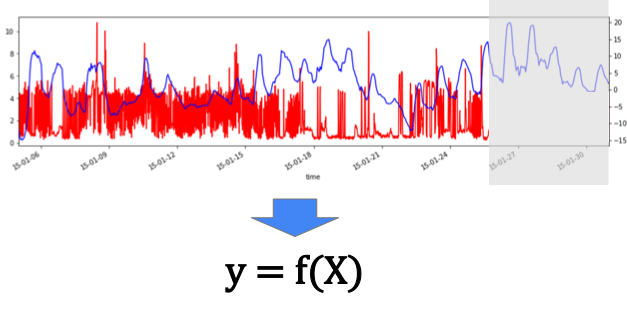 |
|:--:|
| *Source: Own figure* |




## Exploratory Data Analysis <a name="eda"></a>

Let's plot the target variable, the power load (kWh, in blue), together with a covariate, outside temperature (celsius, in orange).

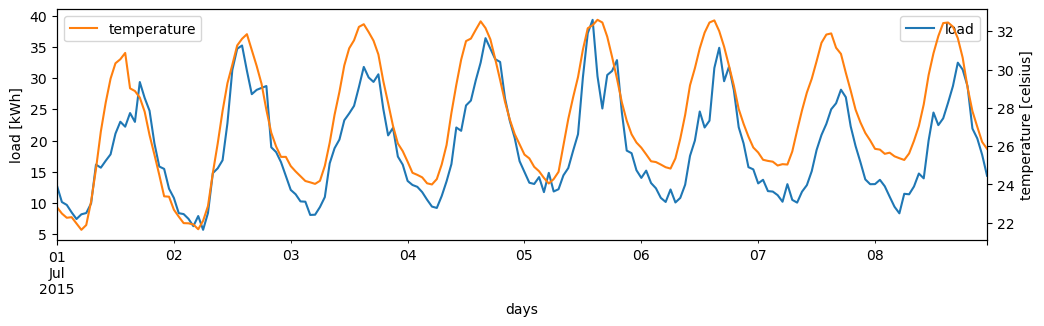

In [5]:
ax = data["2015-07-01":"2015-07-08"].load.plot(figsize=(12,3),label='load')
ax2 = ax.twinx()
data["2015-07-01":"2015-07-08"].temperature.plot(ax=ax2, color="C1",label='temperature')
handles, labels = ax.get_legend_handles_labels()
plt.legend()
ax.legend(handles=handles, labels=labels)
ax2.set_ylabel('temperature [celsius]')
ax.set_ylabel('load [kWh]')
ax.set_xlabel('days');

We can see some correlation between the two series, but the regular pattern also may hint at autocorrelation (read more on autocorrelation for instance [here](https://otexts.com/fpp3/acf.html#acf)). Let's further investigate these relationships:

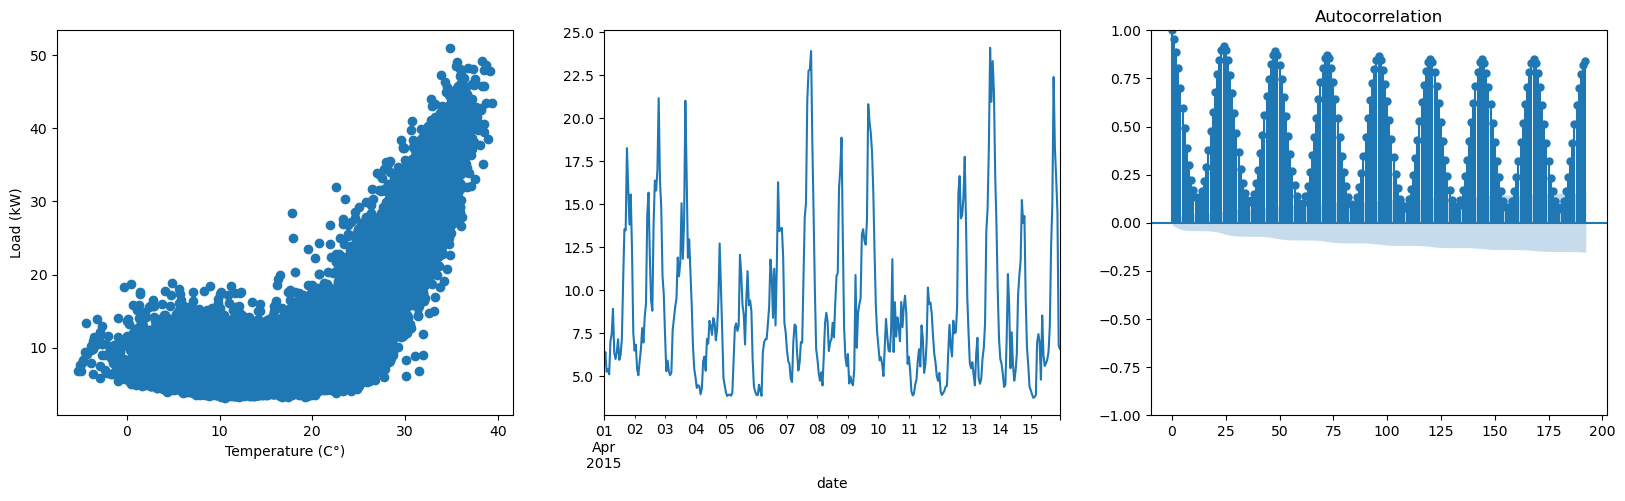

In [6]:
data = pd.read_csv(DATA_URL, parse_dates=[0], index_col=0)

fig, ax = plt.subplots(1,3, figsize=(20,5));
ax[0].scatter(data.temperature, data.load)
ax[0].set_xlabel("Temperature (C°)")
ax[0].set_ylabel("Load (kW)")

data["2015-04-01":"2015-04-15"].load.plot(ax=ax[1])

acf_fig = plot_acf(data.load, ax=ax[2], lags=8*24)

This basic EDA for load data shows that there is:
- a correlation with weather information that can be exploited,
- a seasonal component of daily and weekly pattern that should be modelled,
- autocorrelation at multiple lags that should be considered.

## Load Forecasting Feature Candidates <a name="features"></a>



There are many different things one can *generally* do. Generally in time series forecasting there are the following options:
* Add „lagged“, i.e. prior, values of your target **y** (or other variables) to model autoregressive effects (use autocorrelation plots to figure out which ones are important!),
* Add date time features features (e.g. the day of the week, month of the year, if it is a holiday yes/no, the hour of day) to model seasonal effects,
* Moving window statistics (e.g. averages) of variables,
* Interactions of two or more variables,
* Add features of "known" external correlated time series (here: weather forecast).

While these by itself can inform machine learning models, it may be usefuly to engineer them to more elaborate features, especially for statistical models, e.g.,
* Polynomials of variables to model non-linear effects (especially for simpler models like linear regression),
* Ratios of variables,
* …

In load forecasting the literature the most common features are (see [1]):
* weather-related variables (most importantly, temperature, humidity, solar irradiance)
* Daily, weekly and annual seasonality
* Lagged load
* Socioeconomic indicators (Number of residents, demographics, floor space, tariffs and other interventions, monthly energy consumption)

The following figure schematically shows how the feature matrix $X$ and the target vector $y$ could look for the problem of forecasting electric load:

| 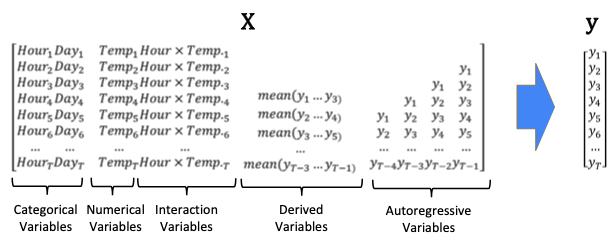 |
|:--:|
| *Source: Own figure.* |

(Note that creating lags leads to NaN values that need to be cut off before training models.)   

The above figure shows how one can forecast one specific point in the future (e.g., *one-step ahead* in the same resolution. Often one needs to forecast several steps ahead. This can generally be achieved using one of the following two approaches (note, hybrids exist):
- a *recursive scheme*, that iteratively predicts one step at a time and uses the former iteration's forecast as input,
- a *direct scheme*, that predicts several steps at once, either as direct output of one model or the output of several models.

The former has the advantage that it can model the dependencies between the steps in the forecast horizon. An disadvantage is that forecast errors can accumluate over the prediction horizon.


| 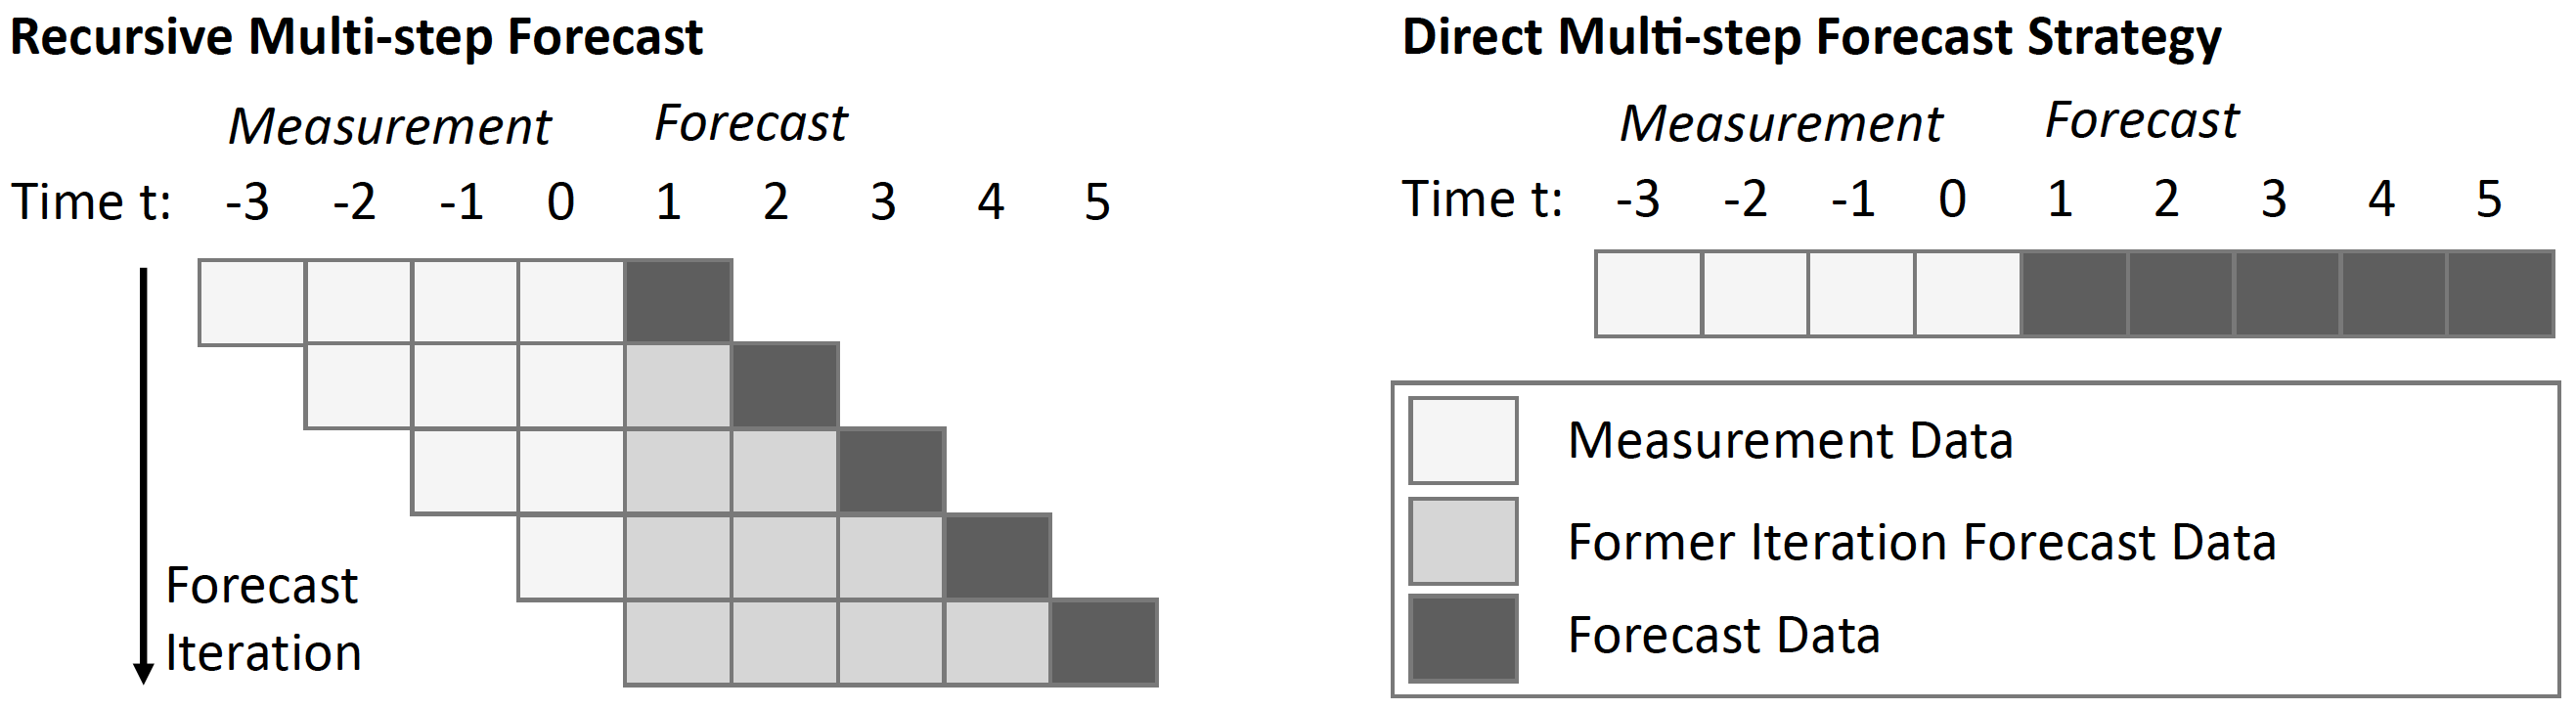 |
|:--:|
| *Source: Own figure.* |

## Encoding Cyclic Calendar-based Features <a name="cyclic"></a>

When encoding calendar-based variables, there are different ways to approach this:
* Encode them as numbers (e.g., January, February, … = 1, 2, ….). **Problem**: Numbers indicate „closeness“, „order“ and linear increasing relationship that may not be useful for all models.
* Dummy-encode/One-Hot-Encode (e.g. Monday, Tuesday, … = (1,0,0,0,0,0,0), (0,1,0,0,0,0,0), …) the variables. This is the most common approach. **Problem**: However, no information about order is preserved. For instance, January and February are somewhat similar. Also, cyclic properties are not preserved, e.g. December and January may also be considered similar.
* Model seasonal properties using Sine and Cosine functions!

As described in [this post,](https://towardsdatascience.com/forecasting-energy-consumption-using-neural-networks-xgboost-2032b6e6f7e2) one can encode the seasonal properties using Sine and Cosine functions as visualised in the following figure from the post:



| <img src="https://miro.medium.com/max/1400/1*GuL5Cq_yBBKY6aqUD0jtDQ.png" alt="Encoding" style="float: left; margin-right: 10px;" />|
|:--:|
| *Source: [Blog Post on Towards Datascience.](https://towardsdatascience.com/forecasting-energy-consumption-using-neural-networks-xgboost-2032b6e6f7e2)* |


## 👉 *Main Take Away Messages*
- *Pandas can handle time series out of the box.*
- *You can frame the forecasting problem as a standard regression problem, so that you can use standard ML methods, by using direct or iterative schemes*
- *The most important features are the seasonal, trend and autoregressive features of the timeseries. Depending on the specific process, external data like the weather can also significantly impact the load.*


# Example Case Study Load Forecasting 🔎 <a name="casestudy"></a>

## Generating Feature Candidates <a name="featurecandidates"></a>

In [7]:
# add sine/cosine encoding for hour of day and month of the year
data["hour_x"] = np.sin(np.radians((360/24) * data.index.hour))
data["hour_y"] = np.cos(np.radians((360/24) * data.index.hour))
data["month_x"] = np.sin(np.radians((360/12) * data.index.month))
data["month_y"] = np.cos(np.radians((360/12) * data.index.month))

# temperature related variables, the mean of last day and lagged by one value, which may better capture the "recency effect"
data["temperature_rolling_mean"] = data.loc[:,"temperature"].rolling(window=24).mean()
data["temperature_lag_1"] = data.temperature.shift(1)

# Add lags up to one day
MAX_LAG = 24
for lag in range(1, MAX_LAG+1):
    data["load_lag_" + str(lag)] = data["load"].shift(lag)

# add calendar-based variables as categorical data
data["day_of_week"] = data.index.weekday
data["hour_of_day"] = data.index.hour
data["month_of_year"] = data.index.month
data["weekend"] = data.index.weekday.isin([5,6])
data = pd.get_dummies(data, columns=["day_of_week", "hour_of_day", "month_of_year"])
data.head()

,load,temperature,hour_x,hour_y,month_x,month_y,temperature_rolling_mean,temperature_lag_1,load_lag_1,load_lag_2,...,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00-06:00,6.378,3.22,0.000000,1.000000,0.5,0.866025,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
2015-01-01 01:00:00-06:00,6.134,3.33,0.258819,0.965926,0.5,0.866025,NaN,3.22,6.378,NaN,...,False,False,False,False,False,False,False,False,False,False
2015-01-01 02:00:00-06:00,6.420,3.14,0.500000,0.866025,0.5,0.866025,NaN,3.33,6.134,6.378,...,False,False,False,False,False,False,False,False,False,False
2015-01-01 03:00:00-06:00,6.129,2.69,0.707107,0.707107,0.5,0.866025,NaN,3.14,6.420,6.134,...,False,False,False,False,False,False,False,False,False,False
2015-01-01 04:00:00-06:00,6.687,2.53,0.866025,0.500000,0.5,0.866025,NaN,2.69,6.129,6.420,...,False,False,False,False,False,False,False,False,False,False


In [8]:
data.columns

Index(['load', 'temperature', 'hour_x', 'hour_y', 'month_x', 'month_y',
       'temperature_rolling_mean', 'temperature_lag_1', 'load_lag_1',
       'load_lag_2', 'load_lag_3', 'load_lag_4', 'load_lag_5', 'load_lag_6',
       'load_lag_7', 'load_lag_8', 'load_lag_9', 'load_lag_10', 'load_lag_11',
       'load_lag_12', 'load_lag_13', 'load_lag_14', 'load_lag_15',
       'load_lag_16', 'load_lag_17', 'load_lag_18', 'load_lag_19',
       'load_lag_20', 'load_lag_21', 'load_lag_22', 'load_lag_23',
       'load_lag_24', 'weekend', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'hour_of_day_0', 'hour_of_day_1', 'hour_of_day_2',
       'hour_of_day_3', 'hour_of_day_4', 'hour_of_day_5', 'hour_of_day_6',
       'hour_of_day_7', 'hour_of_day_8', 'hour_of_day_9', 'hour_of_day_10',
       'hour_of_day_11', 'hour_of_day_12', 'hour_of_day_13', 'hour_of_day_14',
       'hour_of_day_15', 'hour_of_day_16', 'hour_of_da

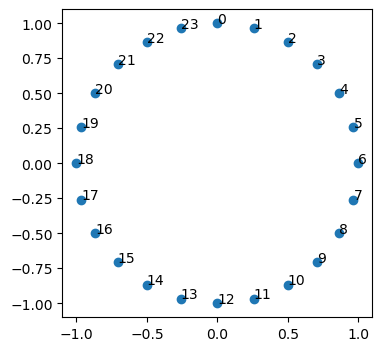

In [9]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
ax.scatter(data["hour_x"].iloc[:24], data["hour_y"].iloc[:24])
for h in range(24):
    ax.annotate(data.index.hour[h], (data["hour_x"].iloc[h], data["hour_y"].iloc[h]))

We have now created 76 features from our 3 initial columns that we are hoping will provide the model with richer predictive information!




## Preparing the model inputs and target <a name="inputoutput"></a>

Here, we follow the *direct* forecasting scheme. The target is prepared for multi-output regression models in shape (n samples, H) with H being the forecast horizon in hours. Of course, feel free to code up an iterative scheme!

In [10]:
H = 24
Y = pd.DataFrame(index = data.index)
for h in range(H):
    Y["h_" + str(h)] = data.load.shift(-h)

Numeric input should be scaled using for instance standardization or min/max scaling. Categorical data should be one-hot encoded (already done above).

In [11]:
scaler = StandardScaler()
numeric_cols = ['temperature'] + [c for c in data.columns if "load_lag" in c]
categorical_cols = [c for c in data.columns if "hour_of_day" in c] + [c for c in data.columns if "day_of_week" in c] + [c for c in data.columns if "month_of_year" in c]
numerics = pd.DataFrame(scaler.fit_transform(data[numeric_cols]), index=data.index, columns=numeric_cols)
categoricals = data[categorical_cols]

X = pd.concat([numerics, categoricals],axis=1)

Note, that generally there are different ways that one can use to preprocess data. Here we use standard scaling, but you may also try Min-/Max-Scaling, Logarithmic Transforms or Box-Cox-Transforms, depending on the models used.


The available data is split up to train and test data. Here, we use a blocked cross-validation scheme (see Section [Cross-validation for time series](#crossvalidation) for some other possible schemes)

In [12]:
X, Y = X.iloc[MAX_LAG:-H,:], Y.iloc[MAX_LAG:-H,:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=False)

## Fitting some baseline models <a name="baseline"></a>




For time series models it can make sense to start with simple benchmarks. For one-step ahead forecasting this may be the *persistence model*, i.e., predicting the same value as in the previous time step. For seasonal data this may also be the value of the last season, e.g., last Monday for a Monday or the value from last year. Or moving averages of the previous timesteps (or previous several seasons). For some seasonal data such *naive models* can be surprisingly hard to beat.

Given the weekly seasonality and task of predicting 24 hours ahead, using last week's load at the same time could be a reasonable benchmark. This model is sometimes referred to as *seasonal persistence* model:

In [13]:
y_hat_naive = Y.shift(168).loc[X_test.index]

y_hat_sma = np.divide(Y.shift(168).loc[X_test.index] + Y.shift(168*2).loc[X_test.index] + Y.shift(168*3).loc[X_test.index] + Y.shift(168*4).loc[X_test.index], 4)

Let's use the mean absolute percentage error as a metric:

In [14]:
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred) * 100

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [15]:
print(f"MAPE Naive: {mape(y_test, y_hat_naive):.2f}, SMA: {mape(y_test, y_hat_sma):.2f}")
print(f"RMSE Naive: {rmse(y_test, y_hat_naive):.2f}, SMA: {rmse(y_test, y_hat_sma):.2f}")

MAPE Naive: 30.36, SMA: 29.17
RMSE Naive: 5.81, SMA: 5.12


Now let's fit some sklearn machine learning models to the data and compare them in term of MAPE.

Our simplest model is the k nearest neighbors.



In [16]:
# Fit a KNN regression model
model = KNeighborsRegressor()
model.fit(X_train, y_train)

y_hat_knn = pd.DataFrame(model.predict(X_test), index=y_test.index)

print(f"MAPE SMA: {mape(y_test, y_hat_sma):.2f}, KNN: {mape(y_test, y_hat_knn):.2f}")

MAPE SMA: 29.17, KNN: 17.25


Great it beat the simple benchmark!

Let's now try another simple model, a L2-penalized linear regression model.

KNN is already capable of multi-output regression to predict the several time steps ahead. The linear model needs to be wrapped in the MultiOutputRegressor model, which fits one model per output variable.

In [17]:
model = MultiOutputRegressor(Ridge())
model.fit(X_train, y_train)

y_hat_linear = pd.DataFrame(model.predict(X_test), index=y_test.index)

print(f"KNN: {mape(y_test, y_hat_knn):.2f}, Ridge Regression: {mape(y_test, y_hat_linear):.2f}")

KNN: 17.25, Ridge Regression: 18.13


Our second model does not provide a significant improvement in terms of MAPE. 😏

One can also compare the forecast to the actual visually by plotting one week. We see that the ridge model captures well the patterns but tends to underestimate peak demand.

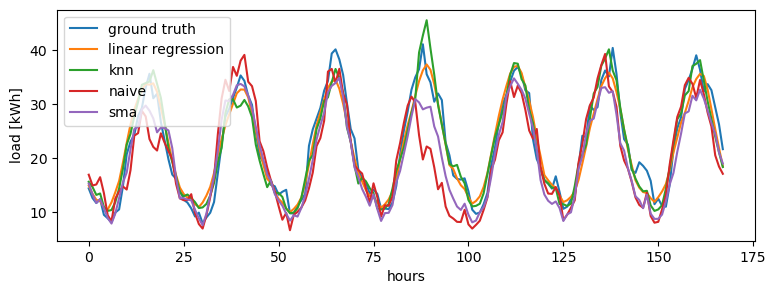

In [18]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(y_test[y_test.index.hour==0].iloc[:7].values.reshape(-1,1),label='ground truth')
ax.plot(y_hat_linear[y_hat_linear.index.hour==0].iloc[:7].values.reshape(-1,1),label='linear regression')
ax.plot(y_hat_knn[y_hat_knn.index.hour==0].iloc[:7].values.reshape(-1,1),label='knn')
ax.plot(y_hat_naive[y_hat_naive.index.hour==0].iloc[:7].values.reshape(-1,1),label='naive')
ax.plot(y_hat_sma[y_hat_sma.index.hour==0].iloc[:7].values.reshape(-1,1),label='sma')
ax.set_ylabel('load [kWh]')
ax.set_xlabel('hours')
plt.legend()

### Exercise 1

⭐ **YOUR TURN!:** No let's use gradient boosting, a machine learning technique that sequentially builds an ensemble of weak models like regression trees with each new model correcting the errors made by the previous models to improve overall predictive performance. [XGBoost](https://xgboost.readthedocs.io/en/stable/) is an efficient and powerful implementation that has been shown to be effective for many structured data problems! Use the [Scikit-Learn Estimator Interface](https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html) to quickly compare it to the above models.

In [19]:
# import your favorite model or the correct model class from XGBoost that is suitable for this task
#import ### YOUR CODE HERE ###
from sklearn.dummy import DummyRegressor # just an import to have code running

# Define the model with sensible parameters
your_model = DummyRegressor() ### YOUR CODE HERE ###

# Fit the model
your_model.fit(X_train, y_train)

# Predict using the model
y_hat_your_model = pd.DataFrame(your_model.predict(X_test), index=y_test.index)

# Print the MAPE for comparison
print(f"KNN: {mape(y_test, y_hat_knn):.2f}, Ridge Regression: {mape(y_test, y_hat_linear):.2f}, Your Model: {mape(y_test, y_hat_your_model):.2f}")

KNN: 17.25, Ridge Regression: 18.13, Your Model: 45.18


#### Solution

Since we are doing regression, you need to choose a _regression_ model. From XGBoost, this is the [XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor). 

For regression tasks, a suitable default objective is ```objective='reg:squarederror'```

Other relevant hyperparameters are:
- ```n_estimators=500```: This parameter specifies the number of boosting rounds, meaning the number of trees to be built. Setting it to 500 provides a good balance between model performance and computational efficiency.
- ```learning_rate=0.1```: The learning rate shrinks the contribution of each tree by the specified amount, making the model's training process more gradual and reducing the likelihood of overfitting. A value of 0.1 is a commonly used default that balances convergence speed and model performance.
- ```max_depth=3```: This parameter sets the maximum depth of each decision tree. A depth of 3 is chosen to prevent overfitting by limiting the complexity of the trees, while still allowing them to capture important patterns in the data.
- ```subsample=0.8```: Subsampling is the fraction of the training data that is randomly sampled to grow each tree. A value of 0.8 helps to prevent overfitting by introducing randomness into the model, making it more robust and less sensitive to noise in the training data.

In [20]:
# import your favorite model or the correct model class from XGBoost that is suitable for this task
from xgboost import XGBRegressor 

# Define the model with sensible parameters
your_model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=3, subsample=0.8, objective='reg:squarederror')

# Fit the model
your_model.fit(X_train, y_train)

# Predict using the model
y_hat_your_model = pd.DataFrame(your_model.predict(X_test), index=y_test.index)

# Print the MAPE for comparison
print(f"KNN: {mape(y_test, y_hat_knn):.2f}, Ridge Regression: {mape(y_test, y_hat_linear):.2f}, Your Model: {mape(y_test, y_hat_your_model):.2f}")

KNN: 17.25, Ridge Regression: 18.13, Your Model: 16.94


### Exercise 2

⭐ YOUR TURN!: Traditional statistical models are often inherently more interpretable. In contrast, such powerful machine learning models can provide more accurate predictions but are often a "black box". However, feature importance methods like [SHAP](https://shap.readthedocs.io/en/latest/index.html) can highlight which variables most influence predictions, offering insights into the model's decision-making process.

XGBoost derives feature importance by calculating metrics when building up the tree model, like _weight_ (the number of times a feature appears in a tree), _gain_ (the average gain of splits which use the feature), and _cover_ (the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split). 

Use the [plot_importance](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.plot_importance) function and try all three types and explore if they can give you insights into the most important features. Plot only the top 10 features.

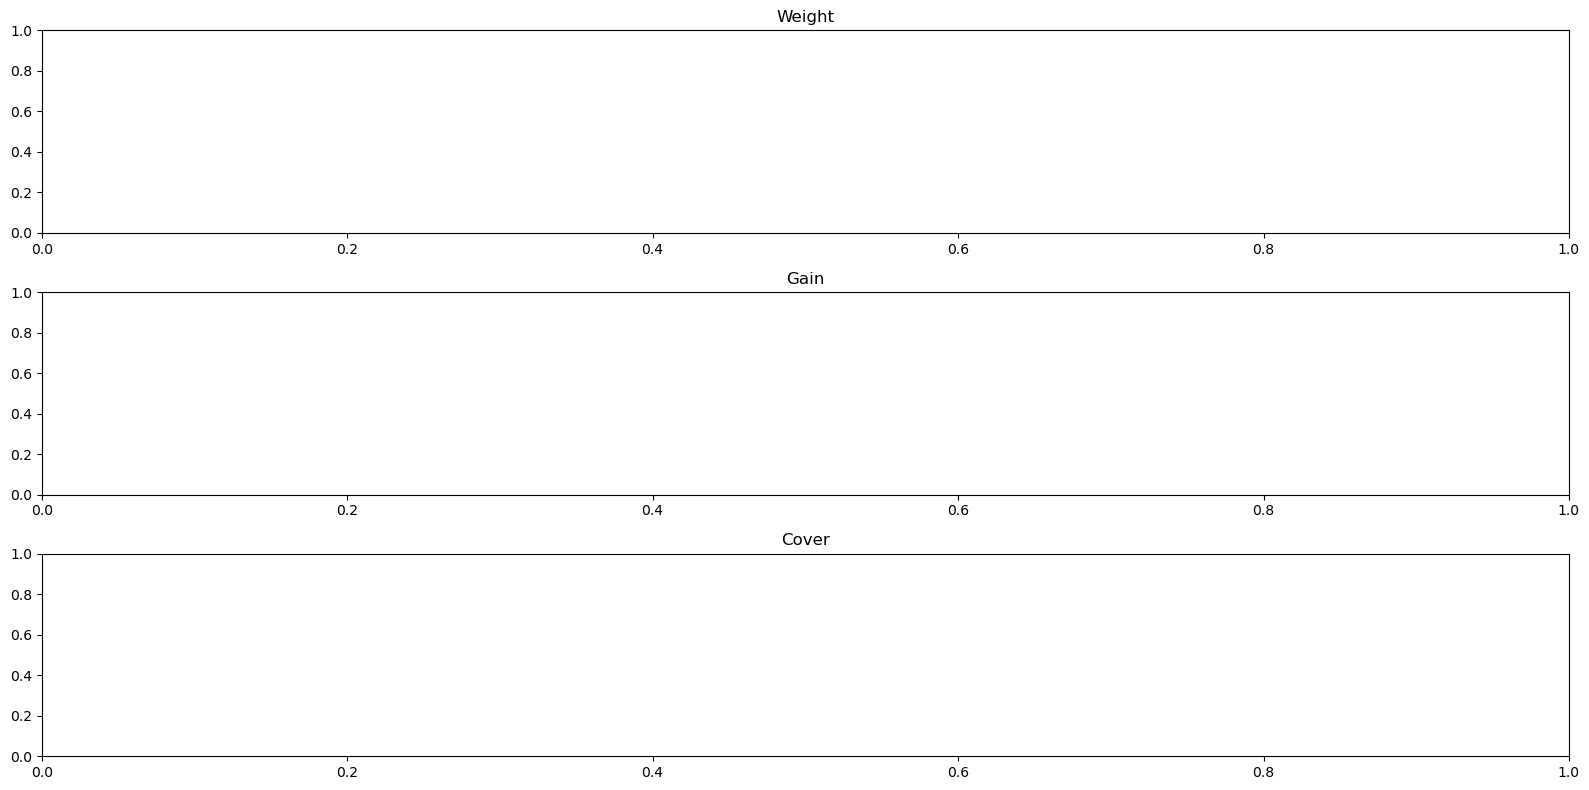

In [21]:
from xgboost import plot_importance

# Create three subplots
fig, ax = plt.subplots(3,1 , figsize=(16, 8))

### YOUR CODE HERE ###
# Use the plt_importance function and pass ax[0] 
ax[0].set_title("Weight")

### YOUR CODE HERE ###
# Use the plt_importance function and pass ax[1] 
ax[1].set_title("Gain")

### YOUR CODE HERE ###
# Use the plt_importance function and pass ax[2] 
ax[2].set_title("Cover")

plt.tight_layout()  # Adjusts the plot to fit into the figure area nicely
plt.show()

#### Solution

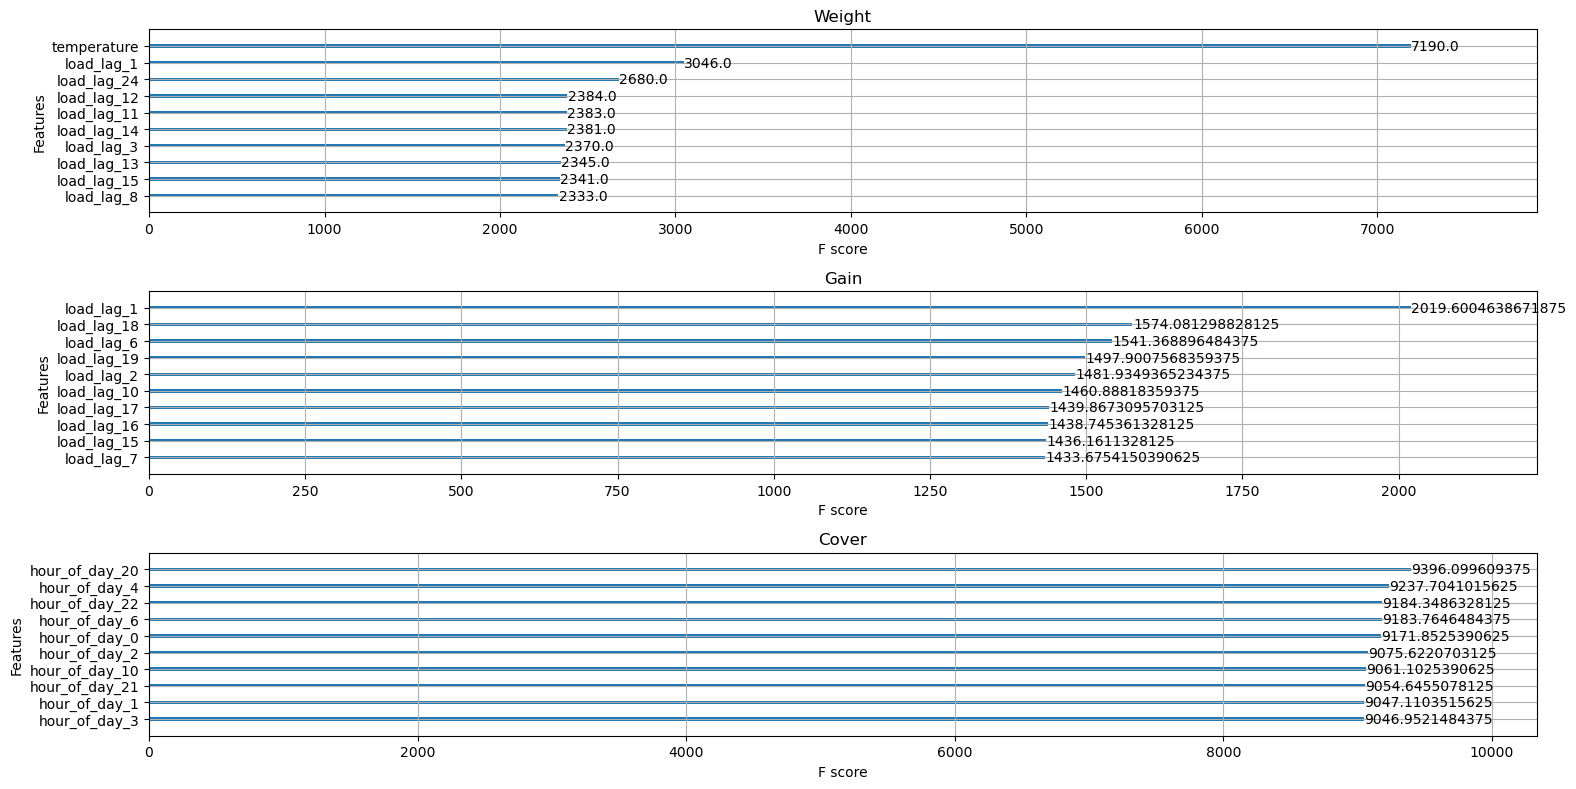

In [22]:
from xgboost import plot_importance
# Plot feature importance
fig, ax = plt.subplots(3,1 , figsize=(16, 8))  # Adjust the figsize to add more space
plot_importance(your_model, importance_type="weight", max_num_features=10, ax=ax[0])
ax[0].set_title("Weight")

plot_importance(your_model, importance_type="gain", max_num_features=10, ax=ax[1])
ax[1].set_title("Gain")

plot_importance(your_model, importance_type="cover", max_num_features=10, ax=ax[2])
ax[2].set_title("Cover")

plt.tight_layout()  # Adjusts the plot to fit into the figure area nicely
plt.show()

You can now see a common problem with feature importance methods. Each method can give you some differnt answer! For _weight_ we can see an answer that we would have expected: the last value before we make a prediction (```load_lag_1```) as well as from 24 hours before (```load_lag_24```) mand the outsite temperature (```temperature```) are the most relevant features for the prediction model

## Comparing Encodings for categorical variables <a name="encodings"></a>

As discussed above, calendar-based categorical variables can be encoded using one-hot encoding or using sine/cosine. The latter has the advantage of using fewer variables and incorporating knowledge about the distance of, for instance, the hours of the day at night (11pm is close to 1 am) or months (January is close to December).

In [23]:
scaler = StandardScaler()
numeric_cols = ["temperature","hour_x", "hour_y", "month_x", "month_y"] + [c for c in data.columns if "load_lag" in c]
numerics = pd.DataFrame(scaler.fit_transform(data[numeric_cols]), index=data.index, columns=numeric_cols)

X_sine = numerics
X_sine = X_sine.iloc[MAX_LAG:-H,:]
X_sine_train, X_sine_test, _, _ = train_test_split(X_sine, Y, test_size=0.25, shuffle=False)

In [24]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_hat = knn.predict(X_test)
print(f"MAPE One-hot encoding: {mape(y_test, y_hat):.2f}")

knn = KNeighborsRegressor()
knn.fit(X_sine_train, y_train)
y_hat = knn.predict(X_sine_test)
print(f"MAPE Sine/Cose Encoding: {mape(y_test, y_hat):.2f}")

MAPE One-hot encoding: 17.25
MAPE Sine/Cose Encoding: 18.23


Here, we find that one hot encoding works better than the sine/cosine encoding.

## Fitting a neural network using Tensorflow <a name="ann"></a>

Finally, we use a simple artificial neural network using Tensorflow. A second popular deep learning library is [PyTorch](https://pytorch.org/). Both are powerful and a preference mostly a matter of taste. There are different ways to model ANN in Tensorflow. For simple archicture, for instance of multiple fully-connected leayers the easiest ist the [Keras Sequential API](https://www.tensorflow.org/guide/keras/sequential_model).

We model a simple fully-connected artificial neural network with two fully-connected layers. We use the __relu__ activation function for the hidden layers. We use the ADAM optimiser to find the optimal weights. Recall that for regression the output layers has a __linear__ activation function and we minimise the __mean squared loss__. More information on all these models an their hyperparameters can be found in <a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_10">Chapter 10</a> in [4].

The `summary()` function shows us the architecture and number of trainable parameters (weights).

In [25]:
model = Sequential()
model.add(Input(shape=X_test.shape[1]))
model.add(Dense(units=15, activation='relu'))
model.add(Dense(units=5, activation='relu'))
model.add(Dense(units=H, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mean_squared_error"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                1035      
                                                                 
 dense_1 (Dense)             (None, 5)                 80        
                                                                 
 dense_2 (Dense)             (None, 24)                144       
                                                                 
Total params: 1,259
Trainable params: 1,259
Non-trainable params: 0
_________________________________________________________________


2024-06-04 13:37:38.641051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


137/137 [==============================] - 0s 529us/step
MAPE ANN: 17.77


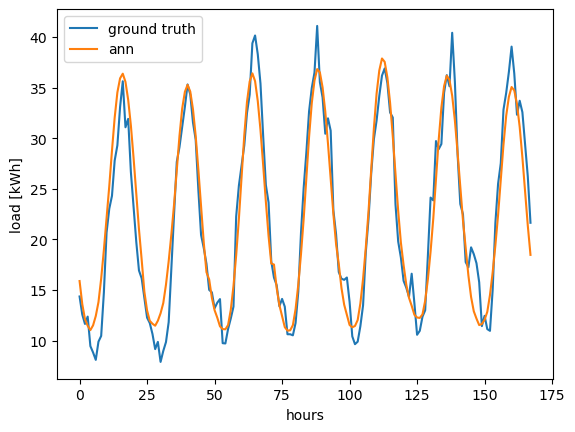

In [26]:
history = model.fit(X_train.values.astype("float32"),
                    y_train.values.astype("float32"),
                    validation_split=0.10,
                    epochs=100,
                    batch_size=16,
                    verbose=False
)

y_hat_ann = pd.DataFrame(model.predict(X_test.astype("float32")), index=y_test.index)
print(f"MAPE ANN: {mape(y_test, y_hat_ann):.2f}")

fig, ax = plt.subplots()
ax.plot(y_test[y_test.index.hour==0].iloc[:7].values.reshape(-1,1),label='ground truth')
ax.plot(y_hat_ann[y_hat_ann.index.hour==0].iloc[:7].values.reshape(-1,1),label='ann')
ax.set_ylabel('load [kWh]')
ax.set_xlabel('hours')
plt.legend()

This model may or may not now perform worse than our initial baseline! If you repeat the process of running the above cell, you will notice that compared to the models above, this time your resulting model will depend on the random initialisation. Some additional tuning is needed to improve the results!

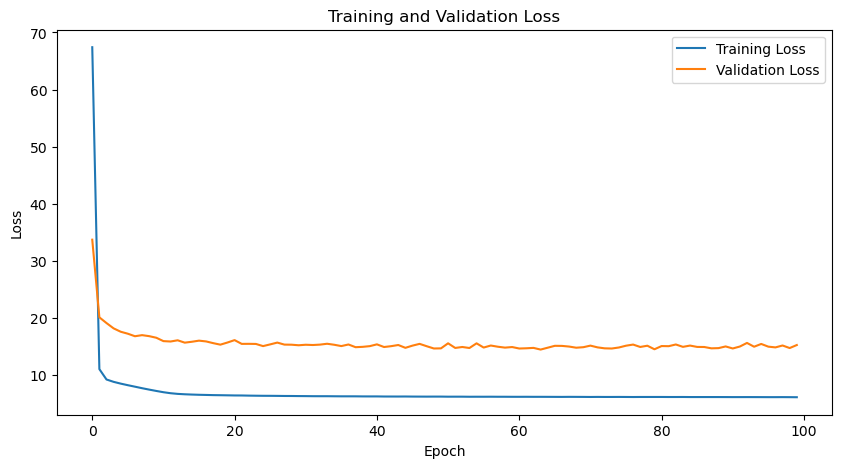

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_title('Training and Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

As a first diagnosis we want to see the learning curve. We can see signs of overfitting as the gap between training and validation loss increases. So some additional tuning is needed to improve and stabilise the results!

Here some ideas to try to improve the model:
- try a smaller architecture,
- try different regularisation methods to avoid possible overfitting,
- try to train the model on more data for your specific problem (use it as a _global model_),
- try to add more features (longer time window?).

### Exercise 3

⭐ YOUR TURN!: Let's try to simplify the architecture by decreasing the model size and add regularisation by adding a drop out layer!

In [28]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Input(shape=X_test.shape[1]))
### YOUR CODE HERE ###
model.add(Dense(units=H, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mean_squared_error"])

model.fit(X_train.values.astype("float32"),
        y_train.values.astype("float32"),
        validation_split=0.10,
        epochs=100, batch_size=16, verbose=False
)

y_hat_ann_reg = pd.DataFrame(model.predict(X_test.astype("float32")), index=y_test.index)
print(f"MAPE ANN: {mape(y_test, y_hat_ann):.2f}, MAPE Regularised ANN: {mape(y_test, y_hat_ann_reg):.2f}")

137/137 [==============================] - 0s 465us/step
MAPE ANN: 17.77, MAPE Regularised ANN: 17.98


#### Solution

In [29]:
from tensorflow.keras.layers import Dropout

reg_model = Sequential()
reg_model.add(Input(shape=X_test.shape[1]))
reg_model.add(Dense(units=12, activation='relu')) # reducing node size
reg_model.add(Dropout(0.1))  # Add dropout to reduce overfitting
# removing second hidden layer
reg_model.add(Dense(units=H, activation='linear'))
reg_model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mean_squared_error"])

reg_model.fit(X_train.values.astype("float32"),
        y_train.values.astype("float32"),
        validation_split=0.10,
        epochs=100, batch_size=16, verbose=False
)

y_hat_ann_reg = pd.DataFrame(reg_model.predict(X_test.astype("float32")), index=y_test.index)
print(f"MAPE ANN: {mape(y_test, y_hat_ann):.2f}, MAPE Regularised ANN: {mape(y_test, y_hat_ann_reg):.2f}")

137/137 [==============================] - 0s 490us/step
MAPE ANN: 17.77, MAPE Regularised ANN: 17.45


Depending on the random initialisations, we should now have (slightly) improved the model! However, we are still behind some of the other benchmark models. Have you found a better archicture? 

### Exercise 4

⭐ YOUR TURN!: We could see on the initial learning curve that results haven't improved much after some iterations. Let's try to add more regularisaion by implementing early stopping!

In [30]:
from tensorflow.keras.layers import Dropout

# Add an early stopping callback
### YOUR CODE HERE ###

# Add the callback to the fit call
history_early = reg_model.fit(X_train.values.astype("float32"),
        y_train.values.astype("float32"),
        validation_split=0.10,
        epochs=100, batch_size=16, verbose=False
        ### YOUR CODE HERE ### add parameter
) 

y_hat_ann_reg2 = pd.DataFrame(reg_model.predict(X_test.astype("float32")), index=y_test.index)
print(f"MAPE ANN: {mape(y_test, y_hat_ann):.2f}, MAPE Regularised ANN: {mape(y_test, y_hat_ann_reg2 ):.2f}")

137/137 [==============================] - 0s 435us/step
MAPE ANN: 17.77, MAPE Regularised ANN: 17.30


#### Solution

In [31]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Add an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history_early = reg_model.fit(X_train.values.astype("float32"),
        y_train.values.astype("float32"),
        validation_split=0.10,
        epochs=100, batch_size=16, verbose=False, 
        callbacks=[early_stopping]
)

y_hat_ann_reg2 = pd.DataFrame(reg_model.predict(X_test.astype("float32")), index=y_test.index)
print(f"MAPE ANN: {mape(y_test, y_hat_ann):.2f}, MAPE Regularised ANN: {mape(y_test, y_hat_ann_reg2 ):.2f}")

137/137 [==============================] - 0s 456us/step
MAPE ANN: 17.77, MAPE Regularised ANN: 17.29


Depending on the random initiations, we have further improved the results. Generally we can see that a simpler architecture and regularisation are needed to make ANN competitive with other simpler ML models. ANN really shine, when more data is available, e.g. also of other buildings (read more on global modelling [here](https://link.springer.com/chapter/10.1007/978-3-031-27852-5_13#Sec4))

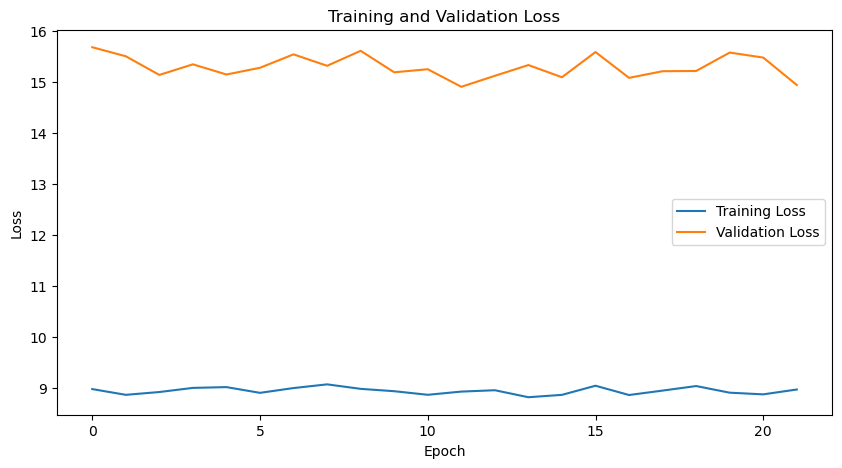

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history_early.history['loss'], label='Training Loss')
ax.plot(history_early.history['val_loss'], label='Validation Loss')
ax.set_title('Training and Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

## Model diagnostics <a name="diagnostics"></a>

A good forecasting method will yield residuals with the following properties:
* *The residuals are uncorrelated.* If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
* *The residuals have zero mean.* If the residuals have a mean other than zero, then the forecasts are biased.

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties:
* The residuals have constant variance.
* The residuals are normally distributed.

The following plots show exemplarily diagnostic plots of a historgram of residuals (top) and the autocorrelation plot of the residuals (bottom).

| |
|:--:|
| <img src="https://otexts.com/fpp3/fpp_files/figure-html/GSPhist-1.png" alt="histogram" style="float: left; margin-right: 10px;" /> |
| <img src="https://otexts.com/fpp3/fpp_files/figure-html/GSPacf-1.png"   alt="residuals AR" style="float: left; margin-right: 10px;" /> |
| *Source: [FPP book](https://otexts.com/fpp3/).* |



In [33]:
step_ahead_errors = y_hat_knn.iloc[:,0]-y_test.iloc[:,0]

Mean: -0.41


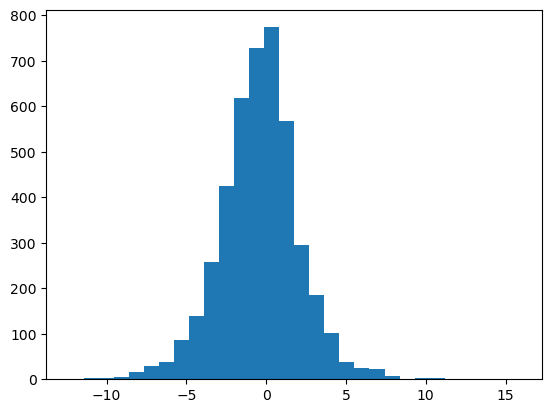

In [34]:
step_ahead_errors = y_hat_knn.iloc[:,0]-y_test.iloc[:,0]
plt.hist(step_ahead_errors, bins=30);
print(f"Mean: {step_ahead_errors.mean():.2f}")

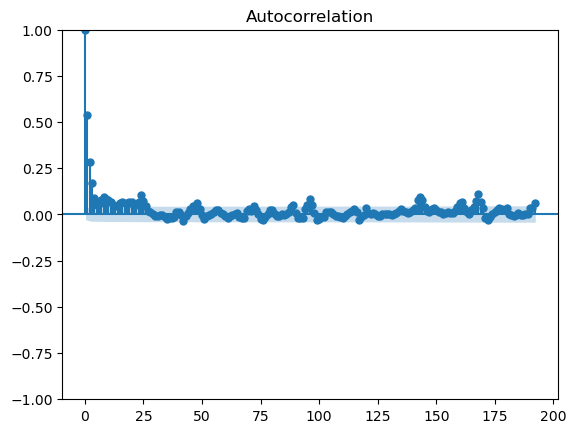

In [35]:
acf = plot_acf(step_ahead_errors, lags=8*24)

The diagnostics show that there is still room for improving the model, as the distribution of errors shows that the model is biased and the autocorrelation shows that there is still information not properly included in the model! For more on forecast verification and evaluation, see [Chapter 7](https://www.springerprofessional.de/en/verification-and-evaluation-of-load-forecast-models/25303772) of [4]

## 👉 *Main Take Away Messages*
- *Start by establishing some simple, but also stronger benchmarks (simple seasonal models and some statistical or simple ML models) before going to more complex models like LSTM, CNN or transformers.*
- *Don't just look at the RMSE, but also use plots of the forecasts and diagnostics plots of the errors to see where your model still fails. Then try different features or feature encodings to improve your model.*


# Common Pitfalls 🕳 <a name="pitfalls"></a>

## Forecasting One-Step ahead <a name="onestepahead"></a>

Often the task is to forecast only one step ahead. For instance, let's consider the task of forecasting tomorrow's closing date of a stock. If we can do this reliably, we are up for some good money! Let's pick the Apple stock as an example.

<Axes: xlabel='Date'>

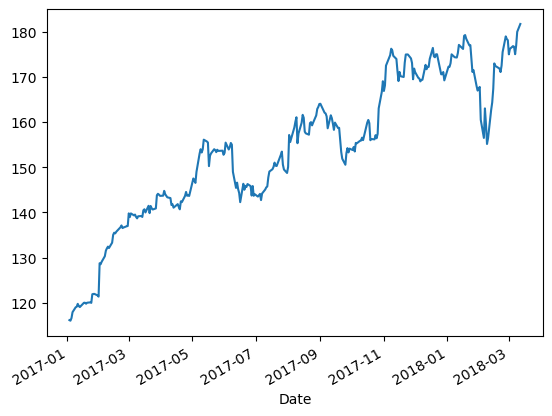

In [36]:
STOCK_URL = "https://raw.githubusercontent.com/AbdelrahmanRadwan/AAPL-Stock-Prices-Analysis/master/DataSet/Dataset.csv"
apple = pd.read_csv(STOCK_URL, parse_dates=[0], index_col=0)
apple["2017":]["Close"].plot(label="Apple")

And let's consider a second stock which was similarly valued at the beginning of the considered period.

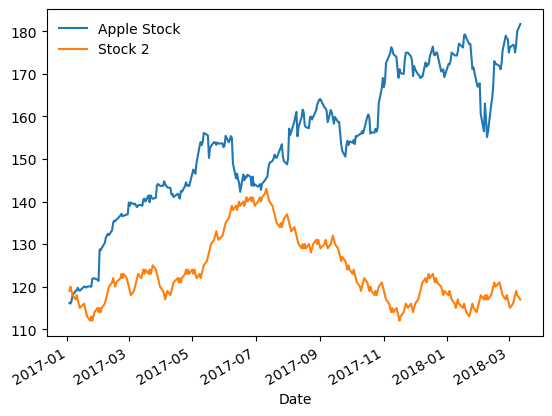

In [37]:
ax = apple["2017":]["Close"].plot(label="Apple Stock")
ax.plot(apple["2017":]["Close"].index, stock2["Close"], label="Stock 2")
ax.legend(frameon=False)

As we don't see seasonal pattern, and we don't have external data available, let's try to use only the series itself, i.e., create some autocorrelation features using the lag function.

In [38]:
MAX_LAG = 7
X_apple = pd.DataFrame(index=apple["2017":].index)
for lag in range(0, MAX_LAG):
    X_apple["Close_lag_" + str(lag)] = apple["2017":]["Close"].shift(lag)

X_stock2 = pd.DataFrame(index=stock2.index)
for lag in range(0, MAX_LAG):
    X_stock2["Close_lag_" + str(lag)] = stock2["Close"].shift(lag)


Y_apple = apple["2017":].Close.shift(-1)
Y_stock2 = stock2.Close.shift(-1)

X_apple, Y_apple = X_apple.iloc[MAX_LAG:-1,:].values, Y_apple.iloc[MAX_LAG:-1].values
X_stock2, Y_stock2 = X_stock2.iloc[MAX_LAG:-1,:].values, Y_stock2.iloc[MAX_LAG:-1].values

X_train_apple, X_test_apple, y_train_apple, y_test_apple = train_test_split(X_apple, Y_apple , test_size=0.25, shuffle=False)
X_train_stock2, X_test_stock2, y_train_stock2, y_test_stock2 = train_test_split(X_stock2, Y_stock2, test_size=0.25, shuffle=False)

Let's again fit a forecast model that worked well last time!

In [39]:
model = Ridge()
model.fit(X_train_apple, y_train_apple)
Y_hat_apple = model.predict(X_test_apple)

model = Ridge()
model.fit(X_train_stock2, y_train_stock2)
Y_hat_stock2= model.predict(X_test_stock2)

Now let's plot the actual and predicted values and calculate the MAPE.

MAPE Apple Stock: 1.07%


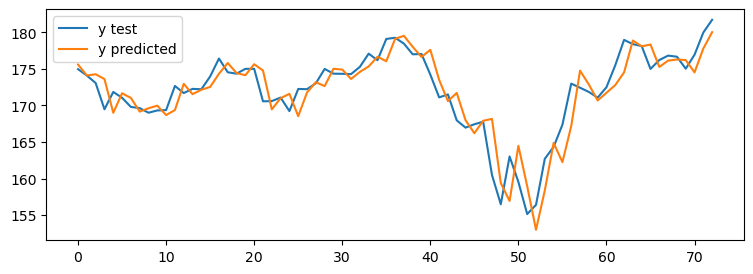

In [40]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(y_test_apple,label='y test')
ax.plot(Y_hat_apple,label='y predicted')
plt.legend()

print(f"MAPE Apple Stock: {mape(y_test_apple, Y_hat_apple):.2f}%")

MAPE Stock 2: 0.83%


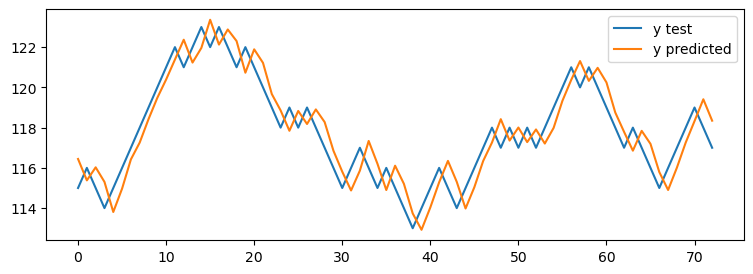

In [41]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(y_test_stock2,label='y test')
ax.plot(Y_hat_stock2,label='y predicted')
plt.legend()
print(f"MAPE Stock 2: {mape(y_test_stock2, Y_hat_stock2):.2f}%")

Awesome! Our predictions look pretty good! Also the MAPE of around 1% are also pretty low! So let's go and make big money! 💰💰💰


...well, what about if I told you, that Stock 2 is a [Random Walk](https://en.wikipedia.org/wiki/Random_walk) 🤔
This means, we are able to predict random numbers?
Something seems not right. Recall from last time, that one should always consider some benchmark. Let's look if we can beat the naive persistence model, i.e., saying that the next value will be the same as the last.

In [42]:
Y_hat_naive_apple = X_test_apple[:,0]
Y_hat_naive_stock2 = X_test_stock2[:,0]

MAPE  Apple Stock: 1.01%


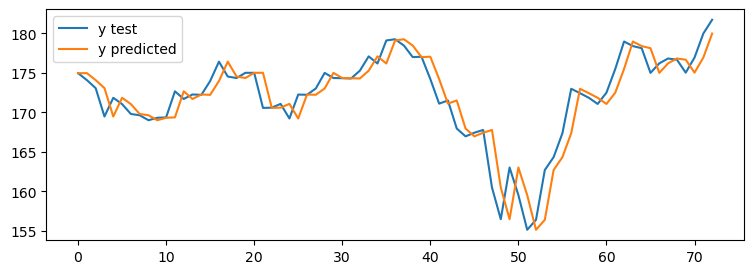

In [43]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(y_test_apple,label='y test')
ax.plot(Y_hat_naive_apple,label='y predicted')
plt.legend()

print(f"MAPE  Apple Stock: { mape(y_test_apple, Y_hat_naive_apple):.2f}%")

MAPE Stock 2: 0.85%


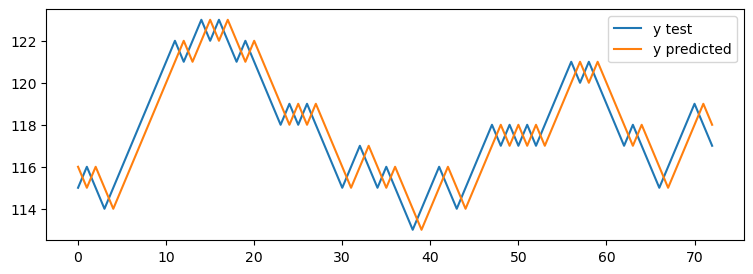

In [44]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(y_test_stock2,label='y test')
ax.plot(Y_hat_naive_stock2,label='y predicted')
plt.legend()

print(f"MAPE Stock 2: {mape(y_test_stock2, Y_hat_naive_stock2):.2f}%")

Mh. So also our naive model predictions are pretty good! But the naive model is just as good as the Ridge forecasting model. What does this mean?

To understand if there is any information that the forecasting model can use from the time series, let's have a look at the autocorrelation plots.

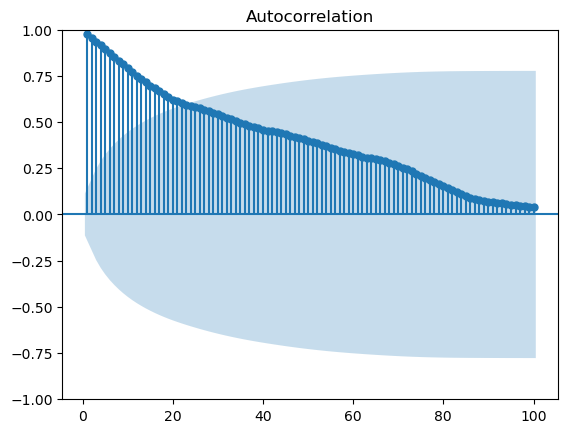

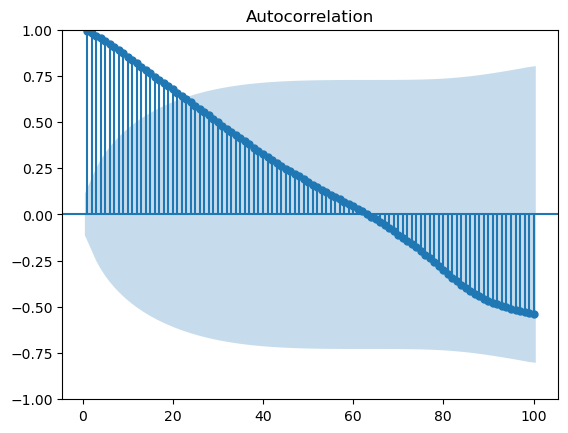

In [45]:
acf = plot_acf(apple["2017":]["Close"], lags=100, zero=False)
acf = plot_acf(stock2["Close"], lags=100, zero=False)

We can now see, that both time series have high autocorrelation with the last values. However, for a random walk this is expected, as the next value is always similar to the last value. This is also true for stocks, as typically a value will be in the range of last day's value (well, not for bitcoin maybe 😉).

However, there is another test one can do to determine if the series are simply random walks: let’s make both time series *stationary* by removing the value of the previous observation from the current observation, i.e., *differencing*. By applying differencing operation we remove the function of time. The following commands do this:

<Axes: title={'center': 'Differenced stock 2 (random walk)'}>

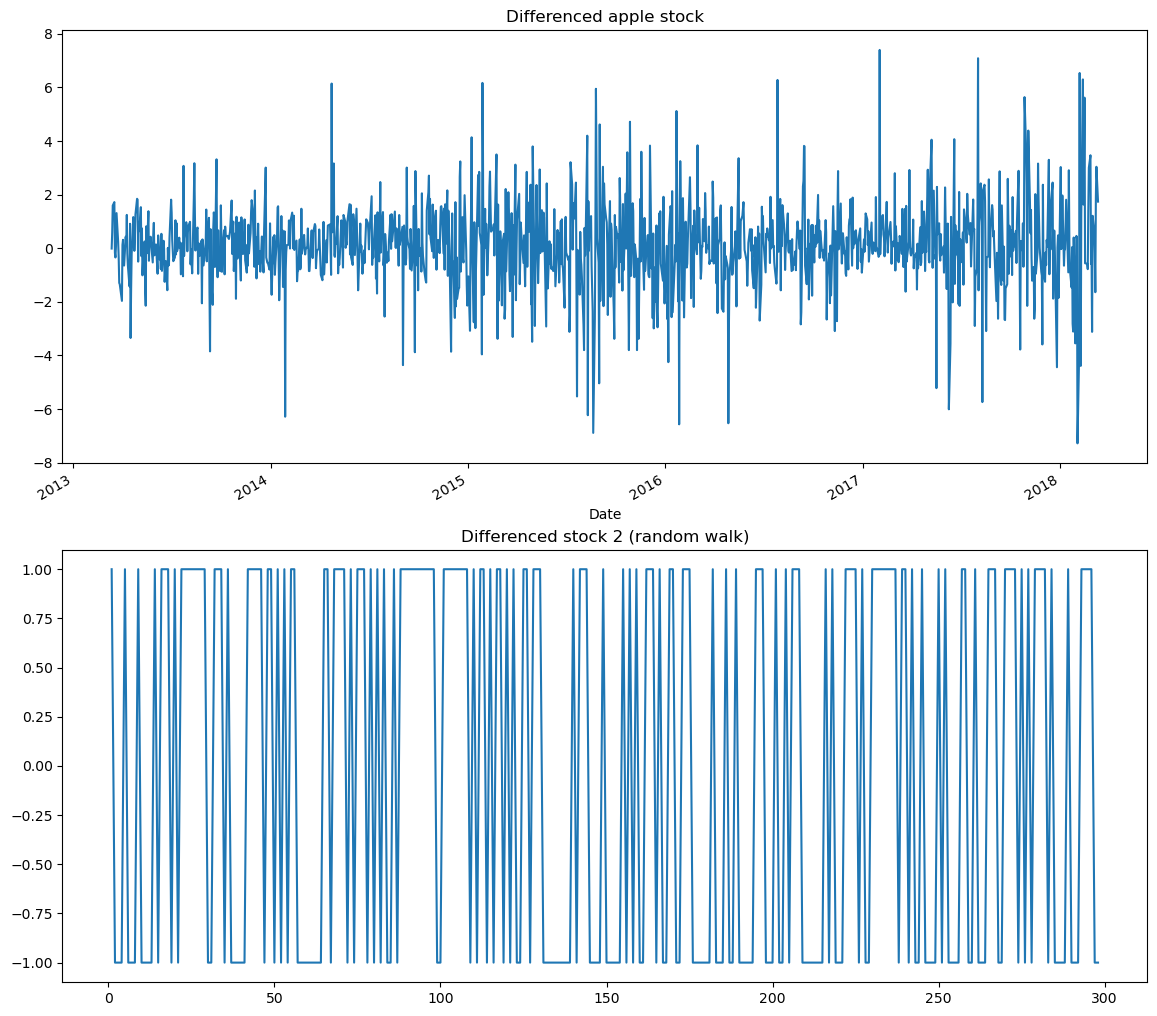

In [46]:
apple_stationary = apple["Close"].diff()[1:]
stock2_stationary = stock2["Close"].diff()[1:]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))
apple_stationary.plot(ax=axes[0], title="Differenced apple stock")
stock2_stationary.plot(ax=axes[1], title="Differenced stock 2 (random walk)")

The random walk time series has only -1 and +1 as expected. The differenced Apple stock has more spikes. But is there some signal one can use to forecast?
We can check this with an autocorrelation plot on the differenced time series:

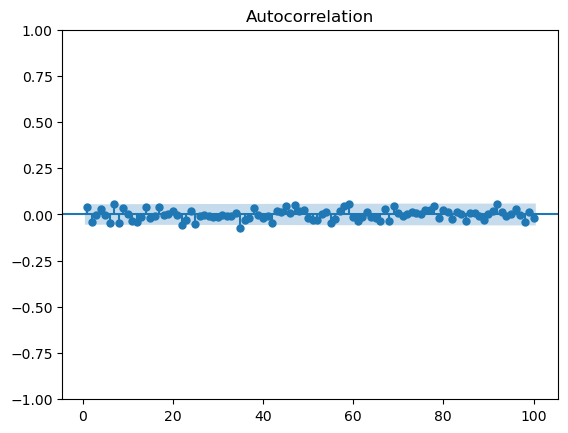

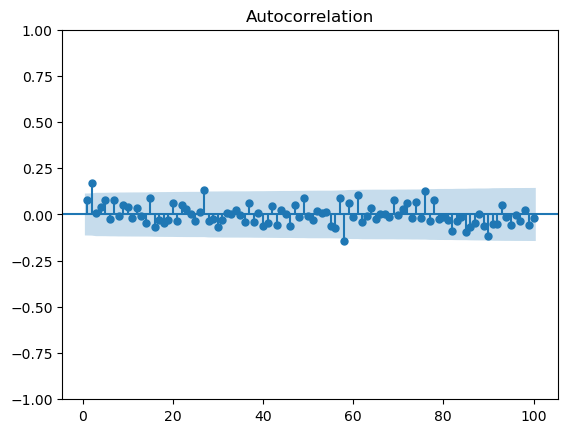

In [47]:
acf = plot_acf(apple_stationary, lags=100, zero=False)
acf = plot_acf(stock2_stationary, lags=100, zero=False)

Autocorrelation values outside of the blue area are statistically significant.There are few autocorrelation values that are over the confidence band for both series. We can attribute these to statistical mistakes and conclude that pretty much both of the series are following more or less a random walk (and hence confirming the [Random walk hypothesis](https://en.wikipedia.org/wiki/Random_walk_hypothesis)?).

## Cross-validation for time series  <a name="crossvalidation"></a>

When trying to compare different version of a model (e.g., trying different features or model hyper-parameters), it is best practice to use *cross validation*. Cross validation is a tool to try to analyze how well a model generalises to new unseen data. Forecast models must be tested on unseen data to ensure that the forecaster is not unrealistically tailoring (subconsciously or otherwise) the model to score higher than would be possible in practice. In real applications the future data is not available and forecasters would not have the advantages of knowing the actual values in advance.

Tuning the parameters can generate substantial performance gain, but this can also lead to overfitting. Thus, we use a cross-validation scheme to understand the impact of several values for the  hyper-parameters by splitting the training set in several training and validation folds. Here, we are tuning the parameter *k* of *k*-nearest neighbor.

We try 3 cross-validation approaches:
- *shuffled*, we take random samples for each fold
- *by blocks*, we take folds that are continuous time blocks all with the same duration     
- *by time series split*, we take folds that are continuous time blocks of different durations (for example fold 1 is two months, fold 2 is three months,...)

See below schematics of blocked (left), time series (middle) and shuffled (right) folds:


| 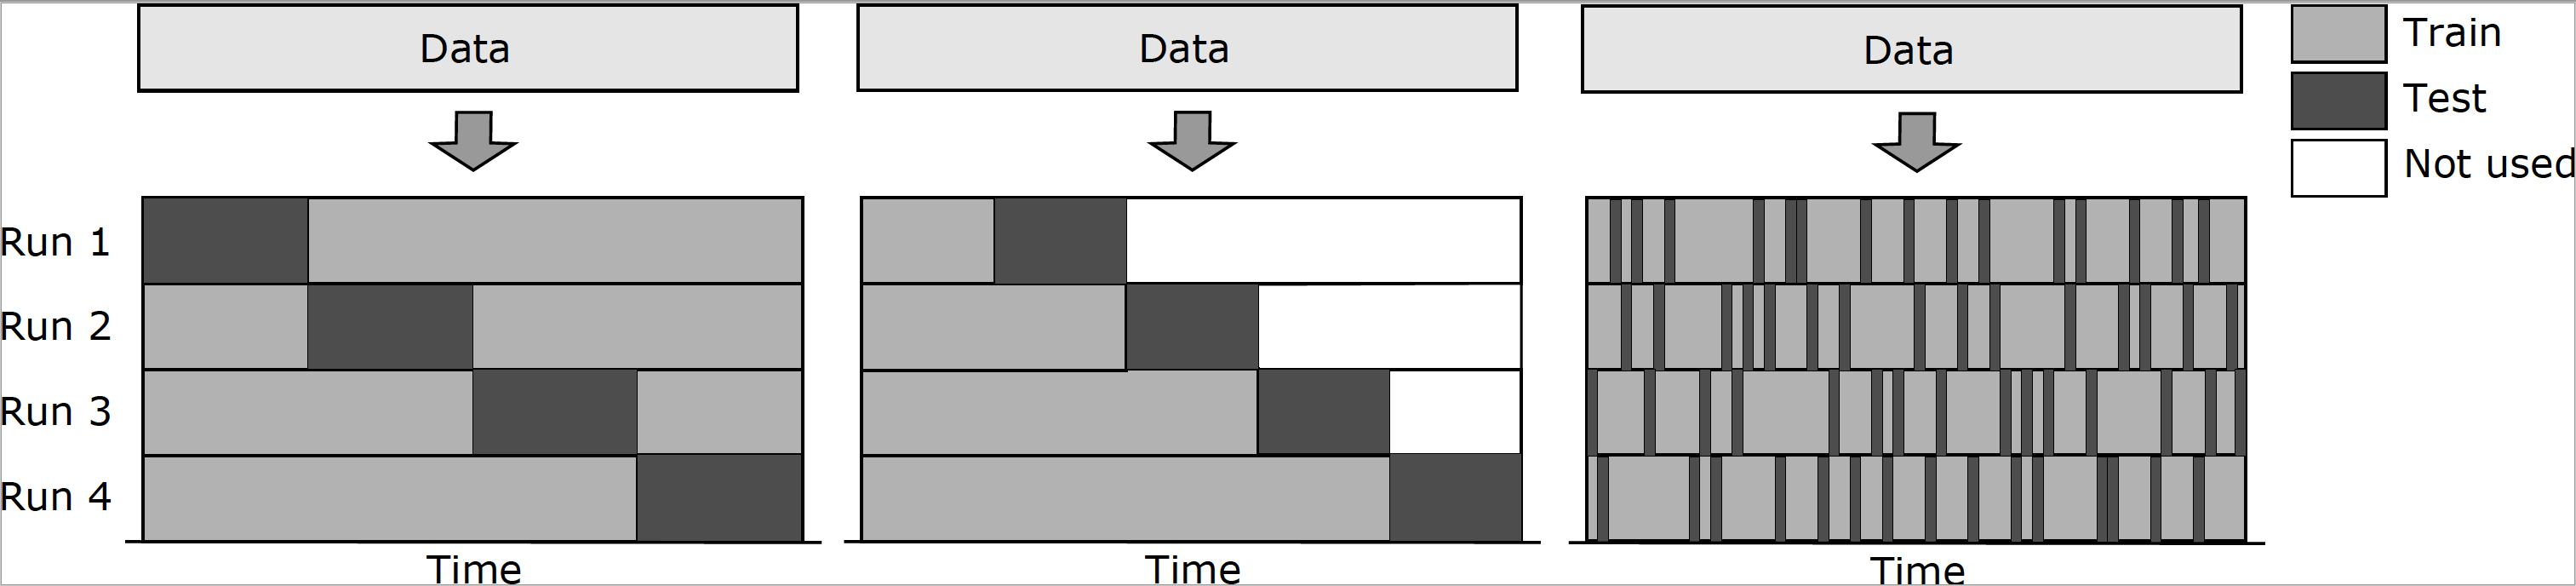 |
|:--:|
| *Source: Own figure.* |



In [48]:
## this block is from last time
data = pd.read_csv(DATA_URL, parse_dates=[0], index_col=0)
# add sine/cosine encoding for hour of day and month of the year
data["hour_x"] = np.sin(np.radians((360/24) * data.index.hour))
data["hour_y"] = np.cos(np.radians((360/24) * data.index.hour))
data["month_x"] = np.sin(np.radians((360/12) * data.index.month))
data["month_y"] = np.cos(np.radians((360/12) * data.index.month))

# temperature related variables, the mean of last day and lagged by one value, which may better capture the "recency effect"
data["temperature_rolling_mean"] = data.loc[:,"temperature"].rolling(window=24).mean()
data["temperature_lag_1"] = data.temperature.shift(1)

# Add lags up to one day
MAX_LAG = 24
for lag in range(1, MAX_LAG+1):
    data["load_lag_" + str(lag)] = data["load"].shift(lag)

# add calendar-based variables as categorical data
data["day_of_week"] = data.index.weekday
data["hour_of_day"] = data.index.hour
data["month_of_year"] = data.index.month
data["weekend"] = data.index.weekday.isin([5,6])
data = pd.get_dummies(data, columns=["day_of_week", "hour_of_day", "month_of_year"])

H = 24
Y = pd.DataFrame(index = data.index)
for h in range(H):
    Y["h_" + str(h)] = data.load.shift(-h)

scaler = StandardScaler()
numeric_cols = ['temperature'] + [c for c in data.columns if "load_lag" in c]
categorical_cols = [c for c in data.columns if "hour_of_day" in c] + [c for c in data.columns if "day_of_week" in c] + [c for c in data.columns if "month_of_year" in c]
numerics = pd.DataFrame(scaler.fit_transform(data[numeric_cols]), index=data.index, columns=numeric_cols)
categoricals = data[categorical_cols]

X = pd.concat([numerics, categoricals],axis=1)
X, Y = X.iloc[MAX_LAG:-H,:], Y.iloc[MAX_LAG:-H,:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=False)


Now let's compare the errors using the three schemes.

In [49]:
N  = 4
knn = KNeighborsRegressor()
knn_parameters = {"n_neighbors" : [3, 6, 12, 18, 24]}

# Using shuffle=False, the KFold represents "blocked cross-validation", i.e. consequitive blocks remain together
gs_cv_block = GridSearchCV(knn, knn_parameters, scoring="neg_mean_squared_error", cv=KFold(n_splits=N, shuffle=False), n_jobs=-1, return_train_score=True)
gs_cv_block.fit(X_train, y_train)
print(gs_cv_block.best_params_)
y_hat = gs_cv_block.predict(X_test)
print(f"Test MAPE Blocked: {mape(y_test, y_hat):.2f}")

# Using shuffle=True, the KFold represents regular, completely shuffled cross-validation
gs_cv_shuffle = GridSearchCV(knn, knn_parameters, scoring="neg_mean_squared_error", cv=KFold(n_splits=N, shuffle=True), n_jobs=-1, return_train_score=True)
gs_cv_shuffle.fit(X_train, y_train)
print(gs_cv_shuffle.best_params_)
y_hat = gs_cv_shuffle.predict(X_test)
print(f"Test MAPE Shuffled: {mape(y_test, y_hat):.2f}")

gs_cv_ts = GridSearchCV(knn, knn_parameters, scoring="neg_mean_squared_error", cv=TimeSeriesSplit(n_splits=N), n_jobs=-1, return_train_score=True)
gs_cv_ts.fit(X_train, y_train)
print(gs_cv_ts.best_params_)
y_hat = gs_cv_ts.predict(X_test)
print(f"Test MAPE Time Series CV: {mape(y_test, y_hat):.2f}")

{'n_neighbors': 24}
Test MAPE Blocked: 16.66
{'n_neighbors': 12}
Test MAPE Shuffled: 16.74
{'n_neighbors': 24}
Test MAPE Time Series CV: 16.66


First comparing the result of the test set, they all improve on the baseline model that is not tuned and are having a similar effect. However, they result in slightly different results. How to choose your scheme?

In cross-validation schemes, an important consideration is that the folds should generally be independent and follow the distribution of the actual data. Also you want to use as much of your data as possible. We analyze this by plotting the negative MSE errors of the different folds.

<Axes: xlabel='None-param_n_neighbors', ylabel='level_0'>

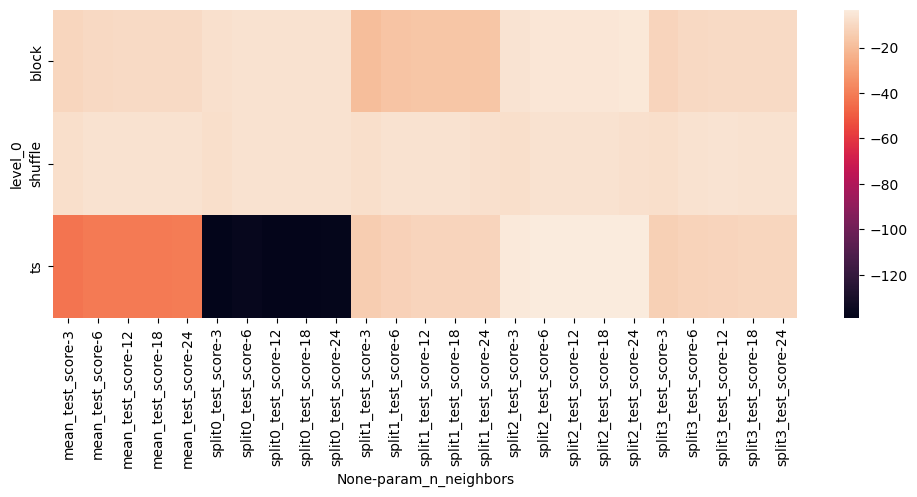

In [50]:
cv_results = pd.concat([pd.DataFrame(gs_cv_ts.cv_results_), pd.DataFrame(gs_cv_shuffle.cv_results_), pd.DataFrame(gs_cv_block.cv_results_)], keys=["ts", "shuffle", "block"]).reset_index()
fig, ax = plt.subplots(figsize=(12,4))
sns.heatmap(cv_results.pivot(index="level_0", columns="param_n_neighbors", values=["mean_test_score", "split0_test_score", "split1_test_score", "split2_test_score", "split3_test_score"]), ax=ax)

We see that the errors across folds are similar for shuffled and blocked CV, but some folds have much higher errors for time split.

For the time series scheme, this is due to the fact that the distribution in the folds varies much due to the yearly seasonality, hence violating the latter assumption of the same distribution. The shuffled scheme has a more stable distributions across the folds, compared to the other schemes. However, given the lagged, auto-correlation variables, the shuffled scheme violates the independence assumption, as data "leaks" between the folds. This may by alright, if errors are uncorrelated (see [3] if you want to deep dive this topic). A blocked scheme with some large N could be a compromise here. However, the shuffled and blocked themes are essentially using data from "the future", which may also be not alright in settings where your time series is non-stationary, as this may make your model overly confident.

## 👉 *Main Take Away Messages*
- Especially one-step ahead forecasts can give you the illusion of a good forecast, as the scale of the series plays into the evaluation. Hence, you should analyse the differenced series, as well. Also, always compare your model to a reasonable benchmark. For one-step ahead forecasting, you must be able to reliably beat the persistence forecast, otherwise you may be trying to predict a random walk.
- The cross-validation scheme you choose will be determinant to get good generalization results. An unrealistic cross-validation scheme may produce overly-optimistic results on the validation set that will in turn lead to poor results on the unseen test set. A time series specific split should most often be the starting point. However, if this leads to problems with your available data, a blocked theme can be also appropriate. Read more on this [here](https://arxiv.org/pdf/2203.10716.pdf).


# Where to go from here? 🧭  <a name="sota"></a>

Some ideas on where to contribute in the area of ML and load forecasting:
- *Better Bechmarking Frameworks*: Currently, there are a lot of papers that don't compare their models to each other, as a standardized benchmark (framework) is missing. A huge benefit to the load forecasting community would be reference implementations and standardised datasets (contact me if you are interested in contributing :)),
- *State-of-the-art deep models*: Can temporal variants of transformers outperform temporal convolutional models?
- *Probabilistic models*: As you see, especially for only few households forecast errors are high. Here, probabsilistic forecasts (intervals, densities, scenarios) can inform more than point forecasts. The marginal distributions are typically complex (multi-model, skewed), hence data-drive approaches can be interesting here!
- *Hierarchical and graphical models*: The electric power system is hierarchial and household locations are spatial information that could be utilised. Consider hierarchical and graphical models for load forecasting!
- *Multivariate models*: Often for buildings there are several relevant time series, e.g. the thermal and electric load as well as load from EV. Given that all of those are depending on similar features (weather, occupancy, ...) once could consider forecasting all domains at once!
- *Online forecasting*: As discussed in the introduction, forecasting is relevant at different spatial dimensions. Some forecasts may be done completely distributed "in the edge". Here, methods that are training "online" withouth access to large storage, could be an interesting direction.

# References 📚

- **[1]** *Haben, S., Arora, S., Giasemidis, G., Voss, M., & Greetham, D. V. (2021). Review of low voltage load forecasting: Methods, applications, and recommendations. Applied Energy, 304, 117798.* [Applied Energy Version](https://www.sciencedirect.com/science/article/abs/pii/S0306261921011326). [Preprint Version](https://arxiv.org/pdf/2106.00006.pdf).
- **[2]** *Rolnick, D., Donti, P. L., Kaack, L. H., Kochanski, K., Lacoste, A., Sankaran, K., ... & Bengio, Y. (2022). Tackling climate change with machine learning. ACM Computing Surveys (CSUR), 55(2), 1-96.* [Link](https://dl.acm.org/doi/full/10.1145/3485128).
- **[3]** *Hewamalage, Hansika, Klaus Ackermann, and Christoph Bergmeir. Forecast Evaluation for Data Scientists: Common Pitfalls and Best Practices. arXiv preprint arXiv:2203.10716 (2022).* [Link](https://arxiv.org/pdf/2203.10716.pdf).
- **[4]** *Haben, S., Voss, M., & Holderbaum, W. (2023). Core Concepts and Methods in Load Forecasting: With Applications in Distribution Networks (p. 331). Springer Nature.* [Link](https://www.springerprofessional.de/en/core-concepts-and-methods-in-load-forecasting/25303748)


# Selected Ressources on Time Series 🎒

## Readings
- Open Access book <a rel="license" href="https://link.springer.com/book/10.1007/978-3-031-27852-5"> Core Methods and Concepts in Load Forecasting </a>: An introductory book on load forecasting techniques with a focus on distribution grids.
- [Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts.](https://otexts.com/fpp3/): It is a classic reference book that is available for free! Written by one of the main forecasting gurus in the world. It contains code examples in R, but is still useful for Pythonistas as it provides insights on many practical time series topics.
- [Introduction to the Fundamentals of Time Series Data and Analysis](https://www.aptech.com/blog/introduction-to-the-fundamentals-of-time-series-data-and-analysis/): A comprehensive blog post on some fundamentals of time series.

See [Appendix C](https://link.springer.com/content/pdf/bbm:978-3-031-27852-5/1?pdf=chapter%20toc) of [4] for more ideas!

## Tools and Libraries

### **Tools in Python** 🐍
- [Smart Meter Data Analysis Tutorial](https://colab.research.google.com/github/bitstoenergy/iclr-tutorial/blob/main/SmartMeterDataAnalytics_Tutorial.ipynb) A Python tutorial that introduces many useful steps in smart meter data analytics from preprocessing, visualising, feature engineering, outlier detection and much more!
- [sktime](https://www.sktime.org/en/stable/) and [tslearn](https://github.com/tslearn-team/tslearn/tree/main/tslearn) are two similar packages that allow to apply sklearn models to time series problems. Both are capable of supporting forecasting, but also clustering and classification tasks. tslearn ist stronger in time series clustering and has implemented many popular time series distance measures such as [Dynamic Time Warping](https://tslearn.readthedocs.io/en/stable/gen_modules/metrics/tslearn.metrics.dtw.html#tslearn.metrics.dtw) or the [Matrix Profile](https://tslearn.readthedocs.io/en/stable/user_guide/matrix-profile.html#matrix-profile) that can be useful in comparing time series and finding (recurring) pattern.
- [statsmodels](https://www.statsmodels.org/devel/api.html#statsmodels-tsa-api) Statsmodels is a general stats library, but it contains different time series specific statistical tests and models.
- [tsfresh](https://tsfresh.readthedocs.io/en/latest/index.html) is a fantastic python package that can automatically calculate a large number of time series features. This can be used for forecasting tasks, but also for classification or clustering of time series.
- [Facebook Prophet](https://facebook.github.io/prophet/): A comprehensive industry-focused suite of a group of forecasting models that automates much of the modeling process.
- [Darts](https://unit8co.github.io/darts/#forecasting-models): Another comprehensive industry-focused suite. It contains strong statistical models like ARIMA or THETA, wrappers for sklearn, strong ML models like Gradient Boosting and deep learning models like LSTM/GRU, NBEATS, TCN and Transformers. It includes also Prophet. Compared to Prophet, this gives you more choices from simple to sophisticated and includes state-of-the-art models from deep learning.
- Visualization: Your favorite Python library will likely also have some ways to plot time series. For simple in the easiest case you can start with a line chart ([Matplotlib](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.plot.html) or [Seaborn](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot)). Others make you handle time series more explicitly like [Plotly](https://plotly.com/python/time-series/). However, besides line plots, you may also consider heat maps, histograms, box plots, scatter plots, and the more specialized plots such as autocorrelation plots are built into [pandas](https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html) or [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.acorr.html). Of course there is a plethora of other specialized sometimes useful plots, e.g. [clock plots](https://github.com/esc-data-science/clock_plot).

### **Tools in R**

- [List of packages by Prof. Hyndamn](https://robjhyndman.com/software/) Prof. Hyndman has co-authored many relevant packages in the R space. From the older very popular [forecast package](https://pkg.robjhyndman.com/forecast/) to "tidyverse" packages [fable](https://github.com/tidyverts/fable) and [feasts](https://github.com/tidyverts/feasts).
- [Facebook Prophet](https://facebook.github.io/prophet/): Prophet (see above) is also available in R.

## Load Datasets

If you are looking for time series data for your analysis, check out the following sources:

- [Low-voltage Load Data](https://low-voltage-loadforecasting.github.io/) A curated list of datasets from house-hold level to feeder level. You know one that is missing? Let me know or raise [an issue](https://github.com/low-voltage-loadforecasting/low-voltage-loadforecasting.github.io/issues)!
- [Monash Time Series Forecasting Repository](https://forecastingdata.org/). This aims to be a standard repository for reproducible research on time series and has some load data.
- [CCAI Wiki](https://wiki.climatechange.ai/wiki/Energy_Demand_Forecasting).Some initial ressources on load forecasting can be found in the CCAI Wiki.

See [Appendix D](https://link.springer.com/content/pdf/bbm:978-3-031-27852-5/1?pdf=chapter%20toc) of [4] for more references or links to specific tools and libraries. 